# CCA Summer School: Landscape of Astronomical Transients

## Day 2: Extracting Physical Properties from Light Curves of Core-Collapse Supernovae

### Prepared by Kohki Uno
- Research Interests: Supernovae, TDEs, and Weird Transients
- Affiliation: Kyoto University -> Columbia University
- Email: <k.uno@kusastro.kyoto-u.ac.jp> or <ku2204@columbia.edu>
- HP: <https://www.kusastro.kyoto-u.ac.jp/~k.uno/view/index.html>

---

# Today's Goals and Summary

- Review the photometric systems and magnitude definitions  
- Reconstruct bolometric light curves via SED fitting using ZTF photometry  
- Fit the bolometric light curves with simple models, and discussed the derived physical parameters

Three assignments have been prepared for you. Please work through them.

---

# Step 0: Environment Setup

Basically we use almost the same modules as day1.

## Required Python Packages:
install  using `pip` or `conda`
- [Astropy](https://www.astropy.org/): Common core package for astronomy
- [Numpy](https://numpy.org/): Scientific mathmatical package
- [Scipy](https://scipy.org/): Scientific mathmatical package
- [Pandas](https://pandas.pydata.org/): Data analysis package
- [Matplotlib](https://matplotlib.org/): Visuallization package
- [alerce.core](https://alerce.readthedocs.io/en/latest/): API for ALeRCe (only for pip)

In [1]:
import os
import json
import time

import requests
from collections import OrderedDict

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

from astropy.time import Time
from astropy.table import QTable
import astropy.units as u
from astropy.constants import h, c, k_B
from astropy.constants import sigma_sb
from astropy.constants import M_sun
from astropy.cosmology import FlatLambdaCDM

from alerce.core import Alerce
alerce = Alerce()  # no authentication needed

/Users/kde/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Set up the save directory (Although it's included in the GitHub repository, it is defined here just in case.)

In [4]:
output_dir = './output_day2/'
os.makedirs(output_dir, exist_ok=True)

## Ancilliary Datasets:

All materials are already included in the GitHub repository (`LSST_summer_school_2025_Flatiron/day2_ccsne`).
If you successfully fork the repository, these files will be downloaded automatically.

- `filter_info.json`: a json file for summerizing filter infromation
- `tns_get_typeII_2022_2024.csv`: a list of Type II supernovae via TNS
- `/lc_alerce`: a directory of light curves queried via ALeRCE
- `ztf_fetching_lc.csv`: a list for successed object for light curve query via ALeRCE
- (`tns_objtype.json`: a json file for summerizing TNS transient types (not explicitly use in this notebook))

---

# Step 1: Photometry in Astronomy

On Day 1, we became familiar with handling ZTF alert data.  
Today, we will take a step further and attempt to derive physical parameters from observed light curve data.

In this first step, we will review the photometric system and explore how observed quantities, such as magnitudes, relate to physical parameters like flux, temperature, and more.

In astronomy, particularly in optical or near-infrared (NIR) observations, we use a unique unit called magnitude. This unit is defined on a logarithmic scale, but its historical definition involves some uncertainty.

This uncertainty arises because optical observations have been conducted for over $\sim 100$ years, during which time no standardized system was initially established. Thus, we now use several photometric systems... These systems specify how observed fluxes are converted into magnitudes, which are logarithmic measures of brightness.

## Remark: Definition of Magnitude

The apparent magnitude $\mathrm{mag}$ of an astronomical object is defined as:

$$
\mathrm{mag} = -2.5 \log_{10} \left( \frac{f_{\mathrm{obs}}}{f_0} \right)
$$

where:
- $\mathrm{mag}$: magnitude of the object  
- $f_{\mathrm{obs}}$: observed flux  
- $f_0$: reference (zero-point) flux

A difference of 1 magnitude corresponds to a flux ratio of $\sim 2.5$, and a difference of 5 magnitudes corresponds to a factor of $\sim 100$ in brightness.


## Vega Magnitude and AB Magnitude Systems

There are multiple magnitude systems, depending on how the zero-point flux $f_0$ is defined. The two most commonly used systems are the Vega magnitude and the AB magnitude systems.

### Vega Magnitude System

- The star **Vega ($\alpha$ Lyrae)** is used as the reference star.
- By definition, Vega has zero magnitude in filters (though small offsets exist in practice).
- This system is widely used in traditional optical and near-infrared astronomy.
- **It is filter-dependent and may vary between instruments**.

### AB Magnitude System

- Defined based on a constant flux per unit frequency ($f_\nu$).
- The AB magnitude is given by:

$$
m_{\mathrm{AB}} = -2.5 \log_{10} \left( \frac{f_\nu}{3631\,\mathrm{Jy}} \right) = -2.5 \log_{10} f_\nu - 48.60
$$

- $f_\nu$: flux density in $[\mathrm{erg/s/cm^2/Hz}]$ or $[\mathrm{Jy}]$  
- 3631 Jy is the reference flux corresponding to zero AB magnitude.
- AB magnitudes provide a consistent and physically meaningful scale across different filters, making them suitable for comparison with theoretical SEDs.

Older observations or literature often use Vega-based magnitudes, but recent surveys and instruments favor the AB system because it is robust and facilitates easier comparison with theoretical models.

## Remark: Filter Function

Another essential concept in photometry is the filter.  
Filters define the wavelength range over which light from an astronomical object is measured. They play a crucial role in determining how flux is recorded and interpreted in different photometric systems.

The observed flux $f_{\mathrm{obs}}$ in a photometric system is determined by the convolution of the object's spectrum or spectral energy distribution (SED) with the system's filter transmission function.

The effective (mean) flux through a filter is given by:

$$
f_{\mathrm{obs}} = \frac{\int f_\lambda(\lambda) T(\lambda) \, d\lambda}{\int T(\lambda) \, d\lambda}
$$

where:
- $f_\lambda(\lambda)$: the object's spectrum / SED in units of [erg/s/cm²/Å]  
- $T(\lambda)$: the filter transmission function  
- $\lambda$: wavelength  

In other words, the observed flux is a weighted mean of the object's flux across the filter bandpass.

## Step 1-1: Confirm the Filter Function of ZTF and LSST

load `filter_info.json` and plot the filter functions as a function of wavelength

In [6]:
file_path = os.path.join(output_dir, 'filter_info.json')
with open(file_path, "r") as f:
    filters = json.load(f)

What acturally in stored in `filters`?

In [7]:
print(filters.keys())
print(filters['ztf_g'].keys())

dict_keys(['ztf_g', 'ztf_r', 'ztf_i', 'lsst_u', 'lsst_g', 'lsst_r', 'lsst_i', 'lsst_z', 'lsst_y'])
dict_keys(['Observatory', 'Instrument', 'filter', 'zeropoint', 'property', 'data'])


It is a dict data including important parameters of filter functions.

`get_filter_table(filters, filter_name)`

Extract the transmission curve, AB zeropoint flux, and effective wavelength for a specified photometric filter.

Arguments:
- `filters` (dict): A dictionary of filter information, typically loaded from a filter response library (e.g., SVO or LSST).
- `filter_name` (str): The name of the filter to extract (e.g., `'ztf_g'`, `'ztf_r'`, `'lsst_u'`, etc.).

Returns:
- `zp_flux` (Quantity): AB zeropoint flux of the filter in units of erg/cm²/s/Å.
- `lambda_eff` (Quantity): Effective wavelength of the filter in Angstroms.
- `table` (QTable): A table containing:
  - `'wavelength'` (Quantity): Wavelength array within the filter range. The wavelength range is clipped using `lambda_min` and `lambda_max` from the filter's metadata.
  - `'transmission'` (float): Corresponding filter transmission (dimensionless).


In [8]:
def get_filter_table(filters, filter_name):

    # Get filter-specific dictionary from the full filter set
    band_data = filters[filter_name]

    # Extract wavelength (in Angstroms) and transmission (unitless)
    wavelength = np.array(band_data['data']['wavelength']) * u.AA
    transmission = np.array(band_data['data']['transmission'])  # dimensionless

    # Apply a wavelength mask to restrict to the valid filter range
    lambda_min = band_data['property']['lambda_min'] * u.AA
    lambda_max = band_data['property']['lambda_max'] * u.AA
    mask = (wavelength > lambda_min) & (wavelength < lambda_max)

    # Extract AB zeropoint flux and effective wavelength
    zp_flux = band_data["zeropoint"]["zp_AB_wav"] * (u.erg / (u.cm**2 * u.s * u.AA))
    lambda_eff = band_data["property"]["lambda_eff"] * u.AA

    # Construct and return a QTable for the filtered wavelength and transmission
    table = QTable()
    table['wavelength'] = wavelength[mask]
    table['transmission'] = transmission[mask]

    return zp_flux, lambda_eff, table


Let's plot the ZTF filter functions!

In [9]:
zp_ztf_g, lambda_ztf_g, filter_ztf_g = get_filter_table(filters, 'ztf_g')
zp_ztf_r, lambda_ztf_r, filter_ztf_r = get_filter_table(filters, 'ztf_r')
zp_ztf_i, lambda_ztf_i, filter_ztf_i = get_filter_table(filters, 'ztf_i')

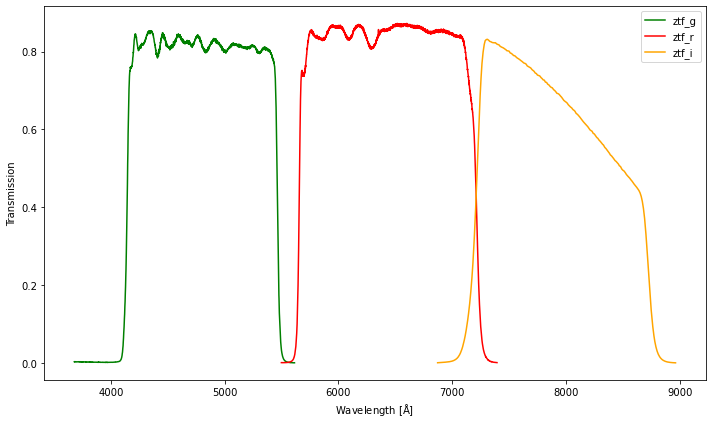

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(filter_ztf_g['wavelength'], filter_ztf_g['transmission'], label='ztf_g', color='green')
ax.plot(filter_ztf_r['wavelength'], filter_ztf_r['transmission'], label='ztf_r', color='red')
ax.plot(filter_ztf_i['wavelength'], filter_ztf_i['transmission'], label='ztf_i', color='orange')

ax.set_xlabel(r'Wavelength [$\mathrm{\AA}$]')
ax.set_ylabel('Transmission')
ax.legend()
plt.tight_layout()
plt.show()

The plot indicates that the ZTF g-band and r-band covers the wavelength of $4000 \mathrm{\AA} - 7200 \mathrm{\AA}$ with a high transmission over 80%

Trun to LSST.

In [11]:
zp_lsst_u, lambda_lsst_u, filter_lsst_u = get_filter_table(filters, 'lsst_u')
zp_lsst_g, lambda_lsst_g, filter_lsst_g = get_filter_table(filters, 'lsst_g')
zp_lsst_r, lambda_lsst_r, filter_lsst_r = get_filter_table(filters, 'lsst_r')
zp_lsst_i, lambda_lsst_i, filter_lsst_i = get_filter_table(filters, 'lsst_i')
zp_lsst_z, lambda_lsst_z, filter_lsst_z = get_filter_table(filters, 'lsst_z')
zp_lsst_y, lambda_lsst_y, filter_lsst_y = get_filter_table(filters, 'lsst_y')

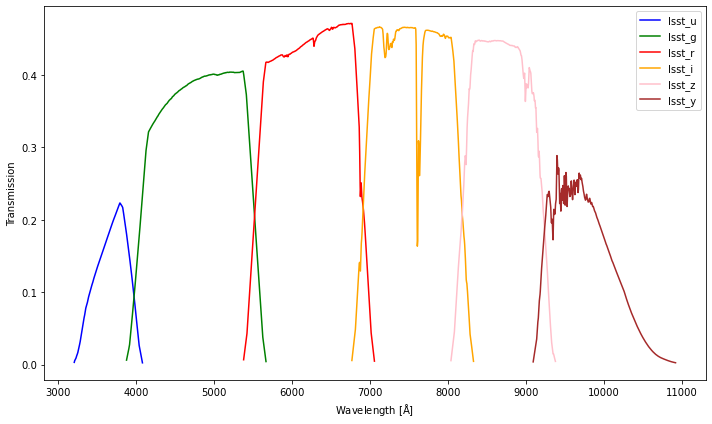

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(filter_lsst_u['wavelength'], filter_lsst_u['transmission'], label='lsst_u', color='blue')
ax.plot(filter_lsst_g['wavelength'], filter_lsst_g['transmission'], label='lsst_g', color='green')
ax.plot(filter_lsst_r['wavelength'], filter_lsst_r['transmission'], label='lsst_r', color='red')
ax.plot(filter_lsst_i['wavelength'], filter_lsst_i['transmission'], label='lsst_i', color='orange')
ax.plot(filter_lsst_z['wavelength'], filter_lsst_z['transmission'], label='lsst_z', color='pink')
ax.plot(filter_lsst_y['wavelength'], filter_lsst_y['transmission'], label='lsst_y', color='brown')

ax.set_xlabel(r'Wavelength [$\mathrm{\AA}$]')
ax.set_ylabel('Transmission')
ax.legend()
plt.tight_layout()
plt.show()

LSST has 6 bands, and cover a more wide spectral range ($\sim 3500\mathrm{\AA} - 10000\mathrm{\AA}$).

In the observations, we measure the flux of objects through specific filters and convert these fluxes into magnitudes.

Next, let’s see how these observed quantities are related to the physical parameters of astronomical objects.

## Remark: Observed Flux from a Distant Source

To understand the intrinsic flux, which is directly linked to physical properties, of an astronomical object, we can model the source as emitting blackbody radiation with temperature $T$ and radius $R$. The observed flux depends on both the intrinsic emission and the distance to the source.

### Planck Function

The specific intensity of a blackbody at temperature $T_{\mathrm{BB}}$ is given by the Planck function:

$$
B_{\lambda}(T) = \frac{2 h c^2}{\lambda^5} \cdot \frac{1}{\exp\left( \frac{h c}{\lambda k_{\mathrm{B}} T_{\mathrm{BB}}} \right) - 1} \quad \text{or} \quad
B_{\nu}(T) = \frac{2 h \nu^3}{c^3} \cdot \frac{1}{\exp\left( \frac{h \nu}{k_{\mathrm{B}} T_{\mathrm{BB}}} \right) - 1}
$$

where:
- $h$: Planck constant  
- $c$: speed of light  
- $k_{\mathrm{B}}$: Boltzmann constant  

### Flux from a Source

The observed flux at a luminosity distance $D_{\mathrm{L}}$ is given by:

$$
f_{\mathrm{obs}}(\lambda) = \pi B_{\lambda}(\lambda, T) \left( \frac{R_{\star}}{D_{\mathrm{L}}} \right)^2
$$

where:
- $R_{\star}$: photospheric radius of the source  

This expression assumes isotropic emission over a hemisphere.

### Luminosity

The luminosity per unit wavelength ($L_{\lambda}$) emitted by the entire surface of a star is given by:

$$
L_\lambda = 4 \pi D_{\mathrm{L}}^2 f_{\mathrm{obs}}(\lambda), \quad L_{\nu} = 4 \pi D_{\mathrm{L}}^2 f_{\mathrm{obs}}(\nu)
$$

Finally, the bolometric luminosity ($L_{\mathrm{bol}}$), which represents the total energy emitted over all wavelengths, is:

$$
L_{\mathrm{bol}} = \int L_{\lambda} \, d\lambda = \int L_{\nu} \, d\nu \approx 4\pi R_{\star}^2 \sigma_{\mathrm{SB}} T_{\mathrm{BB}}^4
$$

where:
- $\sigma_{\mathrm{SB}}$: Stefan–Boltzmann constant  
- $T_{\mathrm{BB}}$: blackbody temperature  

---
---

## Assignment 1: How Bright Is a Supernova?

In this assignment, we will estimate the apparent magnitude of a typical supernova as it would be observed through LSST filters.

Assume the following physical parameters for a supernova around its peak luminosity:
- Temperature: $T_{\mathrm{BB}} = 6000 \mathrm{K}$
- Radius: $R_{\star} = 10^{15} \mathrm{cm}$
- Luminosity distance: $D_{\mathrm{L}} = 100 \mathrm{Mpc}$

Following the steps we have covered:

1. Model the supernova's spectral energy distribution (SED) as blackbody radiation with the given temperature.
2. Calculate the observed flux $f_{\mathrm{obs}}(\lambda)$ using the blackbody spectrum and the source radius and distance.
3. Convolve the spectrum with the LSST filter transmission curves to compute the effective flux through each filter.
4. Convert the flux to AB magnitudes using the AB magnitude definition.

This exercise will help you understand how the intrinsic physical properties of a supernova are translated into observed magnitudes in real photometric surveys.

In [13]:
## YOUR CODE HERE

---
---

`compute_B_lambda(wavelength, temperature)`

Calculate the Planck function in unit of erg/cm^2/s/angstrom/Str.
    
Arguments:
- `wavelength (Quantity)`: Wavelength in Angstrom
- `temperature (Quantity)`: Blackbody temperature of the source in K
    
Returns:
- `B_lambda (Quantity)`: Blackbody function in units of erg/s/cm^2/angstrom/Str.

In [16]:
def compute_B_lambda(wavelength, temperature):
    B_lambda = (2 * h * c**2 / wavelength**5) / (
        np.exp((h * c / (wavelength * k_B * temperature)).decompose()) - 1
        )
    return B_lambda.to(u.erg / (u.cm**2 * u.s * u.Angstrom))


`compute_f_lambda(B_lambda, radius, distance)`

Convert spectral radiance (per steradian) from a blackbody surface into the observed flux density by us, assuming isotropic emission.

Arguments:
- `B_lambda` (Quantity): Spectral radiance in units of erg/cm^2/s/angstrom/sr, typically from the Planck function.
- `radius` (Quantity): Radius of the emitting body (e.g., in cm).
- `distance` (Quantity): Distance to the observer (e.g., in cm).

Returns:
- `f_lambda` (Quantity): Observed flux density in units of erg/cm^2/s/angstrom.

In [17]:
def compute_f_lambda(B_lambda, radius, distance):
    f_lambda = np.pi * B_lambda * (radius**2 / distance**2)
    return f_lambda.to(u.erg / (u.cm**2 * u.s * u.Angstrom))


`compute_filter_flux(f_lambda_obs, f_lambda_wavelength, filter_function)`

Compute the effective flux density of a spectrum passed through a photometric filter.

Arguments:
- `f_lambda_obs` (Quantity): Observed flux density as a function of wavelength, in units of erg / (cm² s Å).
- `f_lambda_wavelength` (Quantity): Wavelength array corresponding to `f_lambda_obs`, in Angstroms.
- `filter_function` (QTable): A filter transmission curve, with:
  - `'wavelength'`: Wavelength grid (Angstroms),
  - `'transmission'`: Dimensionless transmission values (0–1).

Returns:
- `observed_flux` (Quantity): Integrated flux density through the filter in erg / (cm² s Å).


In [18]:
def compute_filter_flux(f_lambda_obs, f_lambda_wavelength, filter_function):

    # Ensure units are consistent
    f_lambda_wavelength = f_lambda_wavelength.to(u.Angstrom)
    f_lambda_obs = f_lambda_obs.to(u.erg / (u.cm**2 * u.s * u.Angstrom))

    # Extract wavelength and transmission from filter curve
    filter_wavelength = filter_function['wavelength']  # [Å]
    filter_transmission = filter_function['transmission']  # unitless

    # Interpolate F_lambda onto the filter wavelength grid
    f_lambda_interpolated = np.interp(
        filter_wavelength.value,     # Target wavelengths
        f_lambda_wavelength.value,   # Original wavelengths
        f_lambda_obs.value           # Original flux values
    ) * f_lambda_obs.unit

    # Perform trapezoidal integration of flux × transmission over wavelength
    numerator = trapezoid(f_lambda_interpolated * filter_transmission, filter_wavelength)

    # Normalize by the integrated transmission curve
    denominator = trapezoid(filter_transmission, filter_wavelength)

    # Final flux density through the filter
    observed_flux = numerator / denominator

    return observed_flux.to(u.erg / (u.cm**2 * u.s * u.Angstrom))


`convert_flux_to_mag(flux, zero_point)`

Convert a flux density value to an apparent magnitude using a logarithmic zeropoint definition.

Arguments:
- `flux` (Quantity): Observed flux density (e.g., in erg / (cm² s Å)).
- `zero_point` (Quantity): Zeropoint flux density of the photometric system (same units as `flux`).

Returns:
- `magnitude` (float): Apparent magnitude computed via:

In [19]:
def convert_flux_to_mag(flux, zero_point):
    return -2.5 * np.log10(flux / zero_point).value

Now that all the preparations are complete, let's calculate the supernova magnitude through the LSST filters and estimate its bolometric luminosity.

In [20]:
wl = np.linspace(1000, 12000, 1000) * u.AA
temperature_SN = 6000 * u.K
radius_SN = 1e15 * u.cm
distance_SN = 100 * u.Mpc

B_lambda_SN = compute_B_lambda(wl, temperature_SN)
f_lambda_SN = compute_f_lambda(B_lambda_SN, radius_SN, distance_SN)

In [21]:
f_fil_lsst_u = compute_filter_flux(f_lambda_SN, wl, filter_lsst_u)
f_fil_lsst_g = compute_filter_flux(f_lambda_SN, wl, filter_lsst_g)
f_fil_lsst_r = compute_filter_flux(f_lambda_SN, wl, filter_lsst_r)
f_fil_lsst_i = compute_filter_flux(f_lambda_SN, wl, filter_lsst_i)
f_fil_lsst_z = compute_filter_flux(f_lambda_SN, wl, filter_lsst_z)
f_fil_lsst_y = compute_filter_flux(f_lambda_SN, wl, filter_lsst_y)

In [22]:
mag_lsst_u = convert_flux_to_mag(f_fil_lsst_u, zp_lsst_u)
mag_lsst_g = convert_flux_to_mag(f_fil_lsst_g, zp_lsst_g)
mag_lsst_r = convert_flux_to_mag(f_fil_lsst_r, zp_lsst_r)
mag_lsst_i = convert_flux_to_mag(f_fil_lsst_i, zp_lsst_i)
mag_lsst_z = convert_flux_to_mag(f_fil_lsst_z, zp_lsst_z)
mag_lsst_y = convert_flux_to_mag(f_fil_lsst_y, zp_lsst_y)

In [23]:
print('apparent magnitudes (AB) from a typical supernova at a distance of 100 Mpc observed by LSST are:')
print(f'u-band: {mag_lsst_u:.2f} mag')
print(f'g-band: {mag_lsst_g:.2f} mag')
print(f'r-band: {mag_lsst_r:.2f} mag')
print(f'i-band: {mag_lsst_i:.2f} mag')
print(f'z-band: {mag_lsst_z:.2f} mag')
print(f'y-band: {mag_lsst_y:.2f} mag')

apparent magnitudes (AB) from a typical supernova at a distance of 100 Mpc observed by LSST are:
u-band: 19.93 mag
g-band: 19.16 mag
r-band: 18.73 mag
i-band: 18.59 mag
z-band: 18.57 mag
y-band: 18.59 mag


In [24]:
L_lambda_SN = 4 * np.pi * distance_SN**2 * f_lambda_SN
L_SN = trapezoid(L_lambda_SN, wl)
print(f'Bolometric luminosity (1000-12000 angstrom) of the SN is {L_SN.to(u.erg/u.s).value:.2e} erg/s')

Bolometric luminosity (1000-12000 angstrom) of the SN is 7.56e+41 erg/s


In [25]:
L_bol = 4*np.pi*radius_SN**2 * sigma_sb*temperature_SN**4
L_bol.to(u.erg/u.s)
print(f'Total bolometric luminosity of the SN is {L_bol.to(u.erg/u.s).value:.2e} erg/s')

Total bolometric luminosity of the SN is 9.23e+41 erg/s


Try changing the wavelength range used for integration and observe how the estimated supernova luminosity (`L_SN`) changes.  
Compare it with the total blackbody luminosity (`L_bol`) and examine the difference.

## Remark: Absolute Magnitude and Distance Modulus

So far, we have calculated the apparent magnitude. However, apparent magnitude depends on the distance to the object. This makes it difficult to directly compare apparent magnitudes between different objects.

To address this, we define the absolute magnitude, which represents how bright an object would appear if it were placed at a standard distance of 10 pc.  
This allows us to compare intrinsic brightness across objects, independent of distance.

### Definition of Absolute Magnitude

The absolute magnitude $M$ is defined as the apparent magnitude $m$ the object would have if it were located at a distance of 10 pc:

$$
M = m - 5 \log_{10} \left( \frac{D_{\mathrm{L}}}{10\,\mathrm{pc}} \right)
$$

- $M$: absolute magnitude  
- $m$: apparent magnitude

### Distance Modulus

The difference between the apparent and absolute magnitudes is known as the distance modulus ($\mu$):

$$
\mu = m - M = 5 \log_{10} \left( \frac{D_{\mathrm{L}}}{10\,\mathrm{pc}} \right)
$$

The distance modulus provides a convenient way to relate observed magnitudes to intrinsic luminosities via distance.


## Step 1-2: Convert Apparent Magnitude to Absolute Magnitude

Using the estimated apparent magnitude of a typical supernova at a distance of 100 Mpc (from Assignment 1). This will allow you to determine the intrinsic brightness of the supernova, independent of distance.

`convert_dL_to_mu(luminosity_distance)`

Converts the luminosity distance to a distance modulus.

Arguments:
- `luminosity_distance (Quantity)`: The luminosity distance.

Returns:
- `distance_modulus (float)`: The distance modulus.

In [26]:
def convert_dL_to_mu(luminosity_distance):
    distance_pc = luminosity_distance.to(u.pc)
    
    # Calculate the distance modulus
    distance_modulus = 5 * np.log10(distance_pc / (10.0*u.pc))
    return distance_modulus

Correct the distance modulous of the supernova.

In [27]:
mu_SN= convert_dL_to_mu(distance_SN)
print(f'distance modulous at 100 Mpc is {mu_SN:.2f}')

distance modulous at 100 Mpc is 35.00


In [28]:
print('absolute magnitudes (AB) from a typical supernova at a distance of 100 Mpc are:')
print(f'u-band: {(mag_lsst_u-mu_SN):.2f} mag')
print(f'g-band: {(mag_lsst_g-mu_SN):.2f} mag')
print(f'r-band: {(mag_lsst_r-mu_SN):.2f} mag')
print(f'i-band: {(mag_lsst_i-mu_SN):.2f} mag')
print(f'z-band: {(mag_lsst_z-mu_SN):.2f} mag')
print(f'y-band: {(mag_lsst_i-mu_SN):.2f} mag')

absolute magnitudes (AB) from a typical supernova at a distance of 100 Mpc are:
u-band: -15.07 mag
g-band: -15.84 mag
r-band: -16.27 mag
i-band: -16.41 mag
z-band: -16.43 mag
y-band: -16.41 mag


This concludes our brief review of photometry.  
Today, we will use these equations and discuss the derived properties.

---

# Step 2: Search Type II supernova

Before we can analyze any transients, we first need to gather the data.  
Although we could continue using the supernova data from Day1, this is a good opportunity to get familiar with another useful method for accessing data.  

## TNS: The Transient Name Server

The [Transient Name Server (TNS)](https://www.wis-tns.org/) is the official IAU database for reporting astronomical transients.  
When a new transient is discovered, it is reported to TNS along with several key pieces of information.

The TNS database provides detailed metadata for each transient, including:

- Discovery date and name (both IAU-designated name and internal survey names)  
- Coordinates (RA and Dec)  
- Spectroscopic classification (e.g., Type Ia, II, IIn, etc.)  
- Redshift and host galaxy information (when available)  
- Discovery instrument and reporting group  

Combining ZTF or LSST alert streams with TNS metadata is a powerful approach for selecting interesting candidates.  
In this exercise, we will learn how to retrieve a list of Type II supernovae (SNe II) using the TNS database.

## Step 2-1: Filtering for Type II Supernovae

To search for specific types of supernovae, such as Type II, we can query the TNS database and apply appropriate filters.

The TNS provides a public API that allows programmatic access to its transient data. However, using the API requires the following:

- Registration for a TNS user account  
- Generation of a personal API key  
- Familiarity with the API request and response structure  

Since API setup and authentication can take a little time (although it’s actually quite easy. Try it if you're interested!), a pre-downloaded dataset is provided for this exercise:  
**`tns_get_typeII_2022_2024.csv`**, containing a list of Type II supernovae reported to TNS within the past three years within z<0.05.

If you would like to try accessing the TNS directly, uncomment the following code cell and insert your API credentials.  
Refer to the following resources for more information:

- [Guide Page](https://www.wis-tns.org/content/tns-getting-started)  
- [API Manual](https://www.wis-tns.org/sites/default/files/api/tns2_manuals/TNS2.0_bulk_reports_manual.pdf)


In [29]:
# tns = "www.wis-tns.org"
# url_tns_api = "https://" + tns + "/api"

# # tns_bot_id = "Here put your tns bot id."
# # tns_bot_name = "Here put your tns bot name."
# # tns_api_key = "Here put your tns api key."

# def set_bot_tns_marker(bot_id, bot_name):
#     tns_marker = 'tns_marker{"tns_id": "' + str(bot_id) + '", "type": "bot", "name": "' + bot_name + '"}'
#     return tns_marker

# def is_string_json(string):
#     try:
#         json_object = json.loads(string)
#     except Exception:
#         return False
#     return json_object

# def print_status_code(response):
#     json_string = is_string_json(response.text)
    
#     ext_http_errors = [403, 500, 503]
#     err_msg = ["Forbidden", "Internal Server Error: Something is broken", "Service Unavailable"]
#     if json_string != False:
#         print ("status code ---> [ " + str(json_string['id_code']) + " - '" + json_string['id_message'] + "' ]\n")
#     else:
#         status_code = response.status_code
#         if status_code == 200:
#             status_msg = 'OK'
#         elif status_code in ext_http_errors:
#             status_msg = err_msg[ext_http_errors.index(status_code)]
#         else:
#             status_msg = 'Undocumented error'
#         print ("status code ---> [ " + str(status_code) + " - '" + status_msg + "' ]\n")

# def search(bot_id, bot_name, api_key, search_obj_list):
#     search_url = url_tns_api + "/get/search"
#     tns_marker = set_bot_tns_marker(bot_id, bot_name)
#     headers = {'User-Agent': tns_marker}
#     json_file = OrderedDict(search_obj_list)
#     search_data = {'api_key': api_key, 'data': json.dumps(json_file)}
#     response = requests.post(search_url, headers=headers, data=search_data)
#     return response

# def get(bot_id, bot_name, api_key, get_obj_list):
#     get_url = url_tns_api + "/get/object"
#     tns_marker = set_bot_tns_marker(bot_id, bot_name)
#     headers = {'User-Agent': tns_marker}
#     json_file = OrderedDict(get_obj_list)
#     get_data = {'api_key': api_key, 'data': json.dumps(json_file)}
#     response = requests.post(get_url, headers = headers, data = get_data)
#     return response

In [30]:
# build_search_obj = [
#     ("classified_sne", "1"),
#     ("internal_name", "ZTF"),
#     ("objtype", [10]), #10-Type II
#     ("public", "1"),
#     ("redshift_max", "0.05"),
# ]
# response_search = search(tns_bot_id, tns_bot_name, tns_api_key, build_search_obj)
# response_search_json = is_string_json(response_search.text)
# search_json_filtered = [
#     obj for obj in response_search_json['data']
#     if any(year in obj.get('objname', '') for year in ['2022', '2023', '2024']) # last 3 years
# ]

# file_path = os.path.join(output_dir, 'tns_search_typeII_2022_2024.json')
# with open(file_path, "w") as f:
#     json.dump(search_json_filtered, f, indent=2)

In [31]:
# tns_get_list = []
# max_retries = 5  # Maximum retry attempts per object

# for obj in search_json_filtered:
#     objname = obj["objname"]
    
#     retries = 0
#     success = False

#     while retries <= max_retries:
#         build_get_obj = [("objname", objname), ("spectra", "1")]
#         response_get = get(tns_bot_id, tns_bot_name, tns_api_key, build_get_obj)
#         get_json = is_string_json(response_get.text)

#         # Check if JSON is valid and contains 'data'
#         if get_json and "data" in get_json:
#             try:
#                 result_data = get_json["data"]

#                 # Extract necessary fields safely
#                 row = {
#                     "tns_name": result_data.get("name_prefix", "") + result_data.get("objname", ""),
#                     "internam_names": result_data.get("internal_names", ""),
#                     "radeg": result_data.get("radeg", ""),
#                     "decdeg": result_data.get("decdeg", ""),
#                     "redshift": result_data.get("redshift", {}),
#                     "discovery_date": result_data.get("discoverydate", ""),
#                     "discovery_mag": result_data.get("discoverymag", ""),
#                     "type": result_data.get("object_type", {}).get("name", "")
#                 }

#                 tns_get_list.append(row)
#                 success = True
#                 break  # Break loop if successful

#             except Exception as e:
#                 print(f"Parsing error: {e}")

#         else:
#             print(f"Failed to fetch or parse data for {objname}")

#         # Retry after waiting 20 seconds
#         retries += 1
#         print(f"Retry {retries}/{max_retries} - Waiting 20 seconds...")
#         time.sleep(20)

#     if not success:
#         print(f"Skipping {objname} after maximum retries.")

# # Create DataFrame from collected rows
# tns_get_df = pd.DataFrame(tns_get_list)

In [34]:
file_path = os.path.join(output_dir, 'tns_get_typeII_2022_2024.csv')
# tns_get_df.to_csv(file_path, index=False)
tns_get_df = pd.read_csv(file_path)

From now on, we will use the dataframe `tns_get_df`.  
What is stored in `tns_get_df`?

In [35]:
tns_get_df.head(10)

,tns_name,internam_names,radeg,decdeg,redshift,discovery_date,discovery_mag,type
0,SN2022aaad,"ATLAS22blqr,ZTF22abtjefa,,PS23bk",117.444284,73.659446,0.010000,2022-11-12 13:43:32.160,16.1450,SN II
1,SN2022aacn,"ZTF22abtmrfr,ATLAS22bltw,PS22lmu,Gaia23ari",11.110125,7.374439,0.017522,2022-11-13 06:50:07.999,18.3968,SN II
2,SN2022aagp,"ZTF22abtspsw,ATLAS22blxx,PS23aoe",137.674603,7.205641,0.004908,2022-11-14 09:25:37.998,15.7649,SN II
3,SN2022aahg,"ZTF22abttbmf,PS22nih",156.001075,-18.554751,0.017000,2022-11-14 11:43:41.088,18.8464,SN II
4,SN2022aaix,"ZTF22abtztxv,Gaia23aby",134.275667,-20.033200,0.018556,2022-11-15 10:36:20.998,18.5717,SN II
5,SN2022aapf,"ZTF22abunrdy,ATLAS23aap,PS23azu",202.456518,-1.430790,0.021280,2022-11-17 13:07:24.997,17.4549,SN II
6,SN2022aapg,"ZTF22abunrnh,ATLAS23aad,PS23bgs",202.230972,-2.262890,0.013000,2022-11-17 13:07:24.997,17.1311,SN II
7,SN2022aasd,"ZTF22abvaxqi,ATLAS22bmgi,PS22mqj",195.380825,36.496614,0.036000,2022-11-16 12:20:55.997,18.3683,SN II
8,SN2022aatu,"ZTF22abtsybt,ATLAS22bmpy,PS23aep",132.828831,1.458007,0.038600,2022-11-14 11:11:02.400,19.1400,SN II
9,SN2022aatx,"ZTF22abulusd,ATLAS22bmiz,PS22lra",138.813834,11.884636,0.017000,2022-11-19 10:39:21.600,17.8700,SN II


How many Type-II supernovae are discovered over 3 years?

In [36]:
print(f'Number of Type II supernova (z<0.05) is {len(tns_get_df)}')

Number of Type II supernova (z<0.05) is 712


## Step 2-2: Calculate Luminosity Distance and Distance Modulus from Redshift

The TNS catalog provides the redshift of each transient (if available).  
However, for many observational analyses, it is more useful to work with the **luminosity distance** and the **distance modulus**, which can be derived from the redshift.

Let's convert the redshift into luminosity distance and compute the corresponding distance modulus. Fortunatelly, `Astropy` provide useful functions to calculate these values.

`convert_redshift_to_dL(redshift, H0=73.2, Om0=0.27)`

Computes the luminosity distance for a given redshift using custom cosmological parameters.

Arguments:
- `redshift (float)`: The redshift.
- `H0 (float)`: Hubble constant [km/s/Mpc].
- `Om0 (float)`: Current matter density parameter.

Returns:
- `luminosity_distance (Quantity)`: The luminosity distance in Mpc.

In [37]:
def convert_redshift_to_dL(redshift, H0=73.2, Om0=0.27):
    
    # Create a custom cosmology
    custom_cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
    # Calculate the luminosity distance for the given redshift
    luminosity_distance = custom_cosmo.luminosity_distance(redshift)

    return luminosity_distance

In [38]:
distance = convert_redshift_to_dL(tns_get_df['redshift'])
mu = convert_dL_to_mu(distance)
tns_get_df['distance'] = distance.value
tns_get_df['mu'] = mu.value

AttributeError: 'Series' object has no attribute 'to'

As preparation for future steps, we will also create a ZTF_name column.

In [32]:
def extract_ztf_name(internal_str):
    if pd.isna(internal_str):
        return np.nan
    # Split by comma and strip whitespace
    names = [name.strip() for name in internal_str.split(',')]
    # Find first name that starts with "ZTF"
    for name in names:
        if name.startswith("ZTF"):
            return name
    return np.nan  # No ZTF name found

In [33]:
# Apply the extraction function to the column
tns_get_df["ztf_name"] = tns_get_df["internam_names"].apply(extract_ztf_name)
ztf_df = tns_get_df[tns_get_df["ztf_name"].notna()]

---

# Step 3: Access ALeRCE and Query Light Curve Data

## Step 3-1: Light Curve Query

Next, let's query the light curve data via ALeRCE (see also Day1 notebook).

Querying light curve data from ALeRCE can take some time. To save time, a set of pre-fetched light curves has been prepared and stored in `./output_day2/lc_alerce`,  
and a list of successfully retrieved sources is available in `ztf_fetching_lc.csv`.

If you would like to try querying the data yourself, uncomment the following cell. (Indeed, we had done in Day1)

In [34]:
lc_dir = os.path.join(output_dir, "lc_alerce")
os.makedirs(lc_dir, exist_ok=True)

`fetch_alerce_lightcurves(oids, output_dir, max_retries=3, sleep_time=1.0, retry_wait=2.0), return_errors=False)`

Fetch lightcurve and forced photometry data from ALeRCE API and save to JSON files.

Arguments
- `oids (list of str)`: List of ZTF object IDs (e.g., ['ZTF23abc...', ...]).
- `output_dir (str)`: Directory where JSON files will be saved.
- `max_retries (int, optional)`: Number of retry attempts per object on failure (default: 3).
- `sleep_time (float, optional)`: Seconds to wait between API calls (default: 1.0).
- `retry_wait (float, optional)`: Seconds to wait between retries on failure (default: 2.0).
- `return_errors (bool)`: flag to save the list of fetching errors.

Returns
- `list`: List of object IDs that failed to fetch after retries.

In [35]:
def fetch_alerce_lightcurves(oids, output_dir, max_retries=3, sleep_time=1.0, retry_wait=2.0, return_errors=False):

    fetching_errors = []

    for i, oid in enumerate(oids, 1):
        # print(f"[{i}/{len(oids)}] Fetching: {oid}")
        
        retries = 0
        success = False

        while retries < max_retries:
            try:
                # Query lightcurve
                lc = alerce.query_lightcurve(oid=oid, format="json")
                detections = lc.get("detections", [])
                non_detections = lc.get("non_detections", [])

                # Query forced photometry
                fp = alerce.query_forced_photometry(oid=oid, format="json")
                forced_detections = fp if isinstance(fp, list) else []

                # Combine into one dictionary
                combined_data = {
                    "detections": detections,
                    "non_detections": non_detections,
                    "forced_detections": forced_detections,
                }

                # Save to file
                output_path = os.path.join(output_dir, f"{oid}.json")
                with open(output_path, "w") as f:
                    json.dump(combined_data, f, indent=2)

                success = True
                break  # success, exit retry loop

            except Exception as e:
                print(f"Error fetching {oid} (attempt {retries + 1}): {e}")
                retries += 1
                time.sleep(retry_wait)

        if not success:
            fetching_errors.append(oid)

        time.sleep(sleep_time)

    print("Done.")
    
    if return_errors:
        return fetching_errors
    else:
        return

Let's query!

In [36]:
# Get OIDs
oids_to_query = [oid for oid in ztf_df["ztf_name"]]
# fetching_errors = fetch_alerce_lightcurves(oids=oids_to_query, output_dir=lc_dir, return_errors=True)

In [37]:
# ztf_fetching_lc_df = ztf_df[~ztf_df["ztf_name"].isin(fetching_errors)].copy()

# Save successful entries
file_path = os.path.join(output_dir, 'ztf_fetching_lc.csv')
# ztf_fetching_lc_df.to_csv(file_path, index=False)

ztf_fetching_lc_df = pd.read_csv(file_path)

## Step 3-2: Plot Queried Light Curves Using Both Apparent and Absolute Magnitude

We have queried light curve data via ALeRCE.  
To inspect the data, let's plot all available light curves using both apparent magnitude and absolute magnitude.

Be sure to normalize the time axis—e.g., by shifting time so that the peak magnitude occurs at $t = 0$.

`plot_lightcurves(df, fid, absolute)`

Plot all light curves from ALeRCE JSON files, aligning time to peak brightness.

Arguments:
- `df` (pandas.DataFrame): DataFrame containing ZTF name and distance modulous of ZTF alerts.
- `fid (int)`: flag of ZTF bands (1=g-band, 2=r-band)
- `absolute (bool)`: True = absolute magnitude, False=apparent magnitude

Returns:
- `None`: Displays a light curve plot

In [38]:
def plot_lightcurves(df=ztf_fetching_lc_df, fid=1, absolute=False):

    json_files = [f"{oid}.json" for oid in df["ztf_name"]]
    band_colors = {1: 'green', 2: 'red', 3: 'orange'}
    band_labels = {1: 'g-band', 2: 'r-band', 3: 'i-band'}

    plt.figure(figsize=(10, 6))

    for json_file in json_files:
        try:
            with open(os.path.join(lc_dir, json_file), "r") as f:
                data = json.load(f)
            detections = data.get("detections", [])
            if not detections:
                continue

            g_detections = [
                d for d in detections
                if d.get("fid") == fid and "magpsf" in d and "sigmapsf" in d
            ]
            if not g_detections:
                continue

            # Sort by time
            g_detections.sort(key=lambda d: d["mjd"])

            # Find peak (minimum magpsf)
            peak_mjd = min(g_detections, key=lambda d: d["magpsf"])["mjd"]

            # Build aligned time and mag
            t = [d["mjd"] - peak_mjd for d in g_detections]
            mag = [d["magpsf"] for d in g_detections]
            
            if absolute:
                obj_info = df[df['ztf_name'] == os.path.splitext(json_file)[0]]
                if not obj_info.empty:
                    mu = obj_info["mu"].values[0]
                    mag = [m - mu for m in mag]

            plt.plot(t, mag, color=band_colors.get(fid, 'gray'), alpha=0.5, linewidth=1)

        except Exception as e:
            print(f"Error processing {json_file}: {e}")
            continue

    plt.gca().invert_yaxis()
    plt.xlabel(f'Days since {band_labels.get(fid, f"band {fid}")} peak')
    if absolute:
        plt.ylabel(f'{band_labels.get(fid, f"band {fid}")} absolute magnitude')
    else:
        plt.ylabel(f'{band_labels.get(fid, f"band {fid}")} apparent magnitude')
    plt.grid(True)
    plt.tight_layout()
    plt.xlim(-30, 150)
    plt.show()


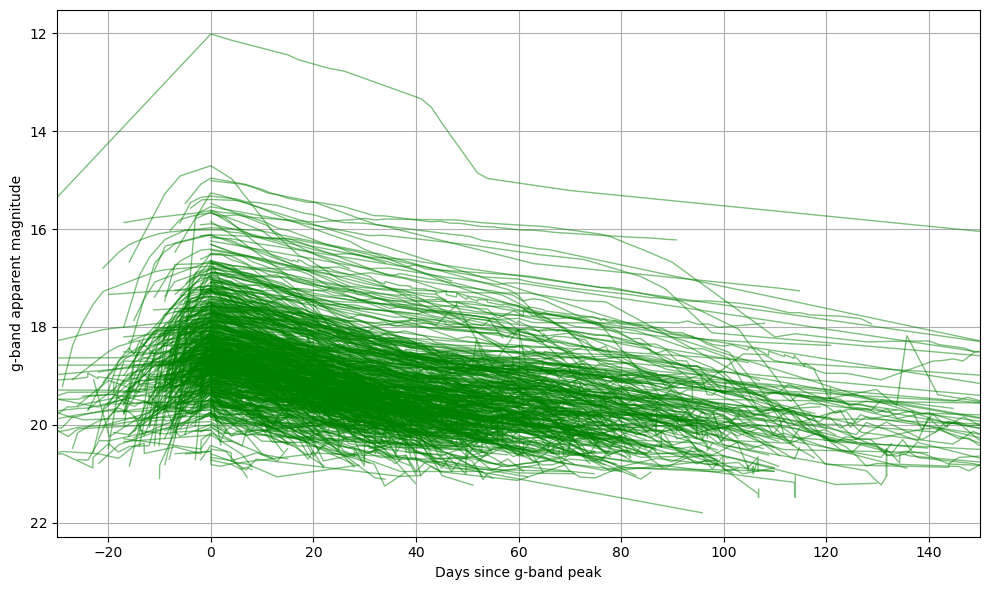

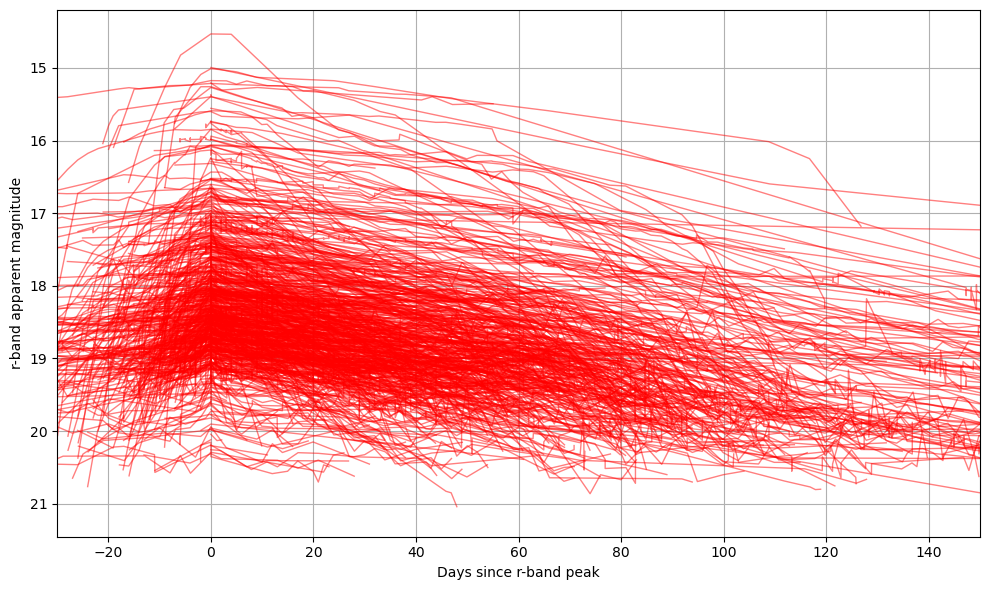

In [39]:
plot_lightcurves(ztf_fetching_lc_df, fid=1)
plot_lightcurves(ztf_fetching_lc_df, fid=2)

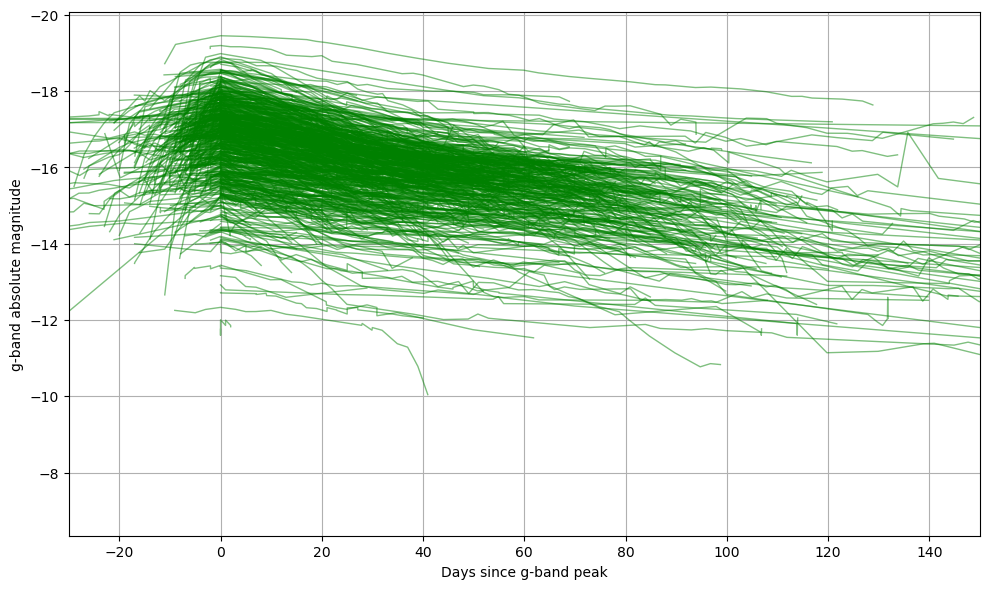

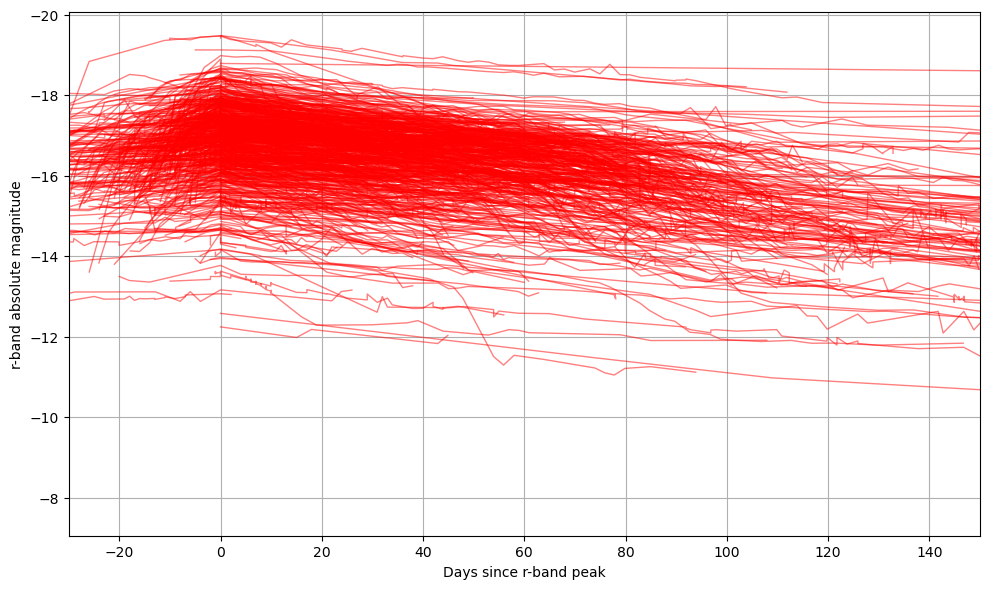

In [40]:
plot_lightcurves(ztf_fetching_lc_df, fid=1, absolute=True)
plot_lightcurves(ztf_fetching_lc_df, fid=2, absolute=True)

We can see that the apparent magnitudes span a wide range, indicating their strong dependence on luminosity distance.  
In contrast, the absolute magnitudes are more tightly clustered, typically $\sim -16$ to $\sim -18$ mag.

Just in case, add a new column of the peak abolute magnitude into `ztf_fetching_lc_df`

`compute_peak_absmag(json_path, mu, fid=1)`

Compute the peak absolute magnitude from a ZTF-style alert JSON file.

Arguments:
- `json_path` (str): Path to the ZTF alert JSON file.
- `mu` (float): Distance modulus to convert apparent magnitude to absolute magnitude.
- `fid` (int, optional): Filter ID to select detections from a specific band (default is 1).

Returns:
- `abs_mag` (float or None): The peak absolute magnitude in the specified filter, or `None` if no valid detections are found or an error occurs.


In [41]:
def compute_peak_absmag(json_path, mu, fid=1):
    try:
        # Load the first object entry from the JSON file
        with open(json_path, "r") as f:
            data = json.load(f)

        # Extract all detections
        detections = data.get("detections", [])

        # Filter detections by filter ID (fid) and ensure "magpsf" is available
        band_detections = [d for d in detections if d.get("fid") == fid and "magpsf" in d]

        # Return None if no valid detections are found
        if not band_detections:
            return None

        # Find the detection with the minimum (brightest) magnitude
        peak_mag = min(band_detections, key=lambda d: d["magpsf"])["magpsf"]
        # Convert to absolute magnitude using distance modulus (mu)
        abs_mag = peak_mag - mu

        return abs_mag

    except Exception as e:
        # Print error message and return None if something goes wrong
        print(f"Error processing {json_path}: {e}")
        return None


In [42]:
peak_abs_g_mags = []
peak_abs_r_mags = []
for _, row in ztf_fetching_lc_df.iterrows():
    oid = row["ztf_name"]
    mu = row["mu"]
    file_path = os.path.join(lc_dir, f"{oid}.json")
    abs_g_mag = compute_peak_absmag(file_path, mu, fid=1)
    abs_r_mag = compute_peak_absmag(file_path, mu, fid=2)
    if abs_g_mag is not None:
        peak_abs_g_mags.append(abs_g_mag)
    elif abs_g_mag is None:
        peak_abs_g_mags.append(np.nan)
    
    if abs_r_mag is not None:
        peak_abs_r_mags.append(abs_r_mag)
    elif abs_r_mag is None:
        peak_abs_r_mags.append(np.nan)
        
ztf_fetching_lc_df['peak_abs_g_mag'] = peak_abs_g_mags
ztf_fetching_lc_df['peak_abs_r_mag'] = peak_abs_r_mags

Plot the distribution of the peak mag, and confirm the typical luminosity of supernovae.

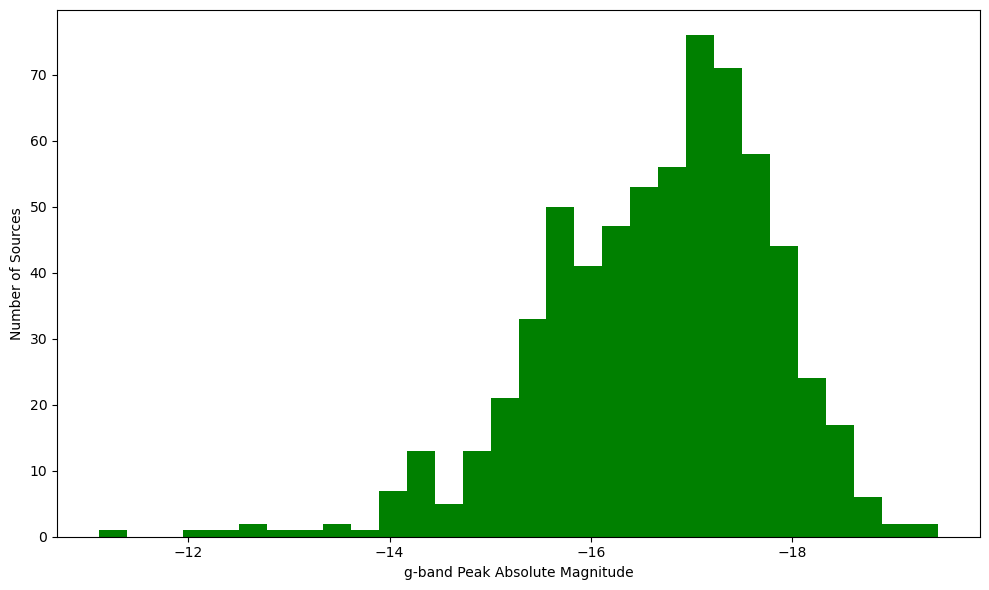

In [43]:
plt.figure(figsize=(10, 6))
plt.hist(ztf_fetching_lc_df['peak_abs_g_mag'], bins=30, color='green')
plt.xlabel("g-band Peak Absolute Magnitude")
plt.ylabel("Number of Sources")
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

## Step 3-3: Extract Well-observed Sample of Light Curves

Not all queried light curves are equally suitable for analysis—some may have sparse data or limited temporal coverage.  
To ensure high-quality results, we will extract a well-observed sample of light curves that satisfy the following criteria:

- Both g- and r-band light curves are available  
- The light curve shows a clear variation in brightness (e.g., it captures rise and decline phases)  
- The observations span a sufficiently wide time range

This gold sample will serve as a reliable subset for further scientific analysis and light curve modeling.

`get_gr_pairs(detections, max_time_diff=0.5)`

Find pairs of g-band and r-band detections from ZTF data that are closely matched in time.

Arguments:
- `detections` (list): List of detection dictionaries, each containing at least `fid`, `mjd`, `magpsf`, and `sigmapsf`.
- `max_time_diff` (float, optional): Maximum allowed time difference (in days) between g- and r-band detections (default is 0.5).

Returns:
- `gr_pairs` (list of tuples): A list where each tuple contains:
  - `g_mjd` (float): MJD of the g-band detection.
  - `g_mag` (float): PSF magnitude in the g-band.
  - `g_sig` (float): PSF magnitude uncertainty in the g-band.
  - `r_mag` (float): PSF magnitude in the r-band.
  - `r_sig` (float): PSF magnitude uncertainty in the r-band.


In [44]:
def get_gr_pairs(detections, max_time_diff=0.5):

    # Extract g-band (fid=1) and r-band (fid=2) detections with valid PSF magnitudes
    g_band = [d for d in detections if d.get("fid") == 1 and "magpsf" in d]
    r_band = [d for d in detections if d.get("fid") == 2 and "magpsf" in d]

    gr_pairs = []

    # For each g-band detection, find the closest r-band detection in time
    for g in g_band:
        g_mjd = g["mjd"]
        g_mag = g["magpsf"]
        g_sig = g["sigmapsf"]

        # Find the r-band detection closest in time
        closest_r = min(r_band, key=lambda r: abs(r["mjd"] - g_mjd), default=None)

        # Check if the time difference is within the specified threshold
        if closest_r and abs(closest_r["mjd"] - g_mjd) <= max_time_diff:
            gr_pairs.append((
                g_mjd,
                g_mag,
                g_sig,
                closest_r["magpsf"],
                closest_r["sigmapsf"]
            ))
    return gr_pairs

`check_significant_variation(detections, fid=1, threshold=2.0)`

Check whether the object shows significant photometric variation in a given filter band.

Arguments:
- `detections` (list): List of detection dictionaries, each containing at least `fid` and `magpsf`.
- `fid` (int, optional): Filter ID to check for variability (default is 1, typically g-band).
- `threshold` (float, optional): Minimum magnitude range to consider variability significant (default is 2.0 mag).

Returns:
- `bool`: `True` if the magnitude range in the specified filter exceeds the threshold, otherwise `False`.

In [45]:
def check_significant_variation(detections, fid=1, threshold=2.0):
    # Extract PSF magnitudes from the specified filter band
    mags = [d["magpsf"] for d in detections if d.get("fid") == fid and "magpsf" in d]

    # If fewer than 2 measurements, cannot evaluate variation
    if len(mags) < 2:
        return False

    # Check if the range of magnitudes exceeds the threshold
    return abs(max(mags) - min(mags)) >= threshold


`check_time_coverage_around_peak(detections, fid=1, days_before=8, days_after=50)`

Check whether the light curve in the specified band sufficiently covers a defined time window around the peak brightness.

Arguments:
- `detections` (list): List of detection dictionaries, each containing at least `fid`, `mjd`, and `magpsf`.
- `fid` (int, optional): Filter ID to select detections (default is 1, typically g-band).
- `days_before` (float, optional): Required time coverage before peak brightness (default is 8 days).
- `days_after` (float, optional): Required time coverage after peak brightness (default is 50 days).

Returns:
- `bool`: `True` if the detections span the desired time window around peak brightness; otherwise, `False`.

In [46]:
def check_time_coverage_around_peak(detections, fid=1, days_before=8, days_after=50):
    
    # Filter detections by filter ID and ensure they have PSF magnitude
    band_detections = [d for d in detections if d.get("fid") == fid and "magpsf" in d]

    # Return False if no detections are available
    if not band_detections:
        return False

    # Sort detections by MJD
    band_detections.sort(key=lambda d: d["mjd"])

    # Find the MJD of the detection with the minimum (brightest) magnitude
    peak_mjd = min(band_detections, key=lambda d: d["magpsf"])["mjd"]

    # Define desired time window around the peak
    min_mjd = peak_mjd - days_before
    max_mjd = peak_mjd + days_after

    # Get the time range of the actual detections
    mjds = [d["mjd"] for d in band_detections]

    # Check if the detection times fully cover the desired time range
    if min(mjds) <= min_mjd and max(mjds) >= max_mjd:
        return True
    else:
        return False


In [47]:
selected_sources = []
for _, row in ztf_fetching_lc_df.iterrows():
    oid = row["ztf_name"]
    file_path = os.path.join(lc_dir, f"{oid}.json")
    if not os.path.exists(file_path):
        continue
    try:
        with open(file_path, "r") as f:
            data = json.load(f)
        detections = data.get("detections", [])

        if (len(get_gr_pairs(detections)) >= 10 and 
            check_significant_variation(detections, fid=1) and
            check_time_coverage_around_peak(detections, fid=1, days_before=8, days_after=100)
            ):
            selected_sources.append(row)
    except Exception as e:
        print(f"Error processing {oid}: {e}")
        continue

ztf_selected_df = pd.DataFrame(selected_sources)

In [48]:
ztf_selected_df.head(10)

,tns_name,internam_names,radeg,decdeg,redshift,discovery_date,discovery_mag,type,distance,mu,ztf_name,peak_abs_g_mag,peak_abs_r_mag
5,SN2022aapf,"ZTF22abunrdy,ATLAS23aap,PS23azu",202.456518,-1.430790,0.021280,2022-11-17 13:07:24.997,17.4549,SN II,88.621746,34.737702,ZTF22abunrdy,-16.743813,-17.610582
18,SN2022acfz,"ATLAS22bngp,PS22mqy,ZTF22abybbud",114.396896,35.605512,0.013343,2022-11-30 11:24:44.064,18.0060,SN II,55.225606,33.710702,ZTF22abybbud,-15.895446,-16.836145
134,SN2022mxv,"ATLAS22qxp,ZTF22aaolwsd,,Gaia22dfc,PS22hho",357.771375,20.152481,0.014046,2022-06-18 13:05:36.384,18.2490,SN II,58.167235,33.823392,ZTF22aaolwsd,-17.698485,-17.753270
185,SN2022uop,"ZTF22abfzdkz,ATLAS22bfqg,PS22jrr",33.993255,1.592625,0.010000,2022-09-17 08:22:33.600,19.6000,SN II,41.280825,33.078742,ZTF22abfzdkz,-15.472322,-15.909612
201,SN2022wza,"ZTF22abkkhao,Gaia22eey,ATLAS22bhxa",48.154708,45.209681,0.010000,2022-10-02 09:25:55.200,20.4200,SN II,41.280825,33.078742,ZTF22abkkhao,-15.813266,-16.142514
212,SN2022yyz,"ZTF22abrexqa,PSP22ag,ATLAS22bkpq",286.756471,28.997246,0.012200,2022-10-29 03:00:29.998,19.2934,SN II,50.449648,33.514291,ZTF22abrexqa,-15.431003,-16.909781
369,SN2023plh,"ZTF23aaxtmrr,ATLAS23rkk,PS23itf",51.015345,34.602836,0.035000,2023-08-14 10:07:47.004,19.4289,SN II,147.299577,35.841008,ZTF23aaxtmrr,-16.847661,-17.047927
424,SN2023vog,"ZTF23abmoxlu,ATLAS23uod,MASTER OT J094509.62+6...",146.290125,68.586589,0.014817,2023-10-21 10:15:06.002,18.5768,SN II,61.397064,33.940738,ZTF23abmoxlu,-17.054994,-17.171418
466,SN2024aasm,"ZTF24abrfiya,ATLAS24qfe,GOTO24iki",346.999416,-8.743635,0.043000,2024-11-08 02:56:53.998,19.1321,SN II,182.063527,36.301115,ZTF24abrfiya,-18.377015,-18.446315
470,SN2024aawr,"ZTF24absbhfe,ATLAS24qjb,GOTO24irq",144.427490,66.296708,0.023000,2024-11-11 08:37:47.003,18.6282,SN II,95.912158,34.909368,ZTF24absbhfe,-16.913263,-16.976668


How many well-observed samples are selected?

In [49]:
print(f'Number of Well-observed Samples is {len(ztf_selected_df)}')

Number of Well-observed Samples is 15


Let's plot the light curves of the selected samples.

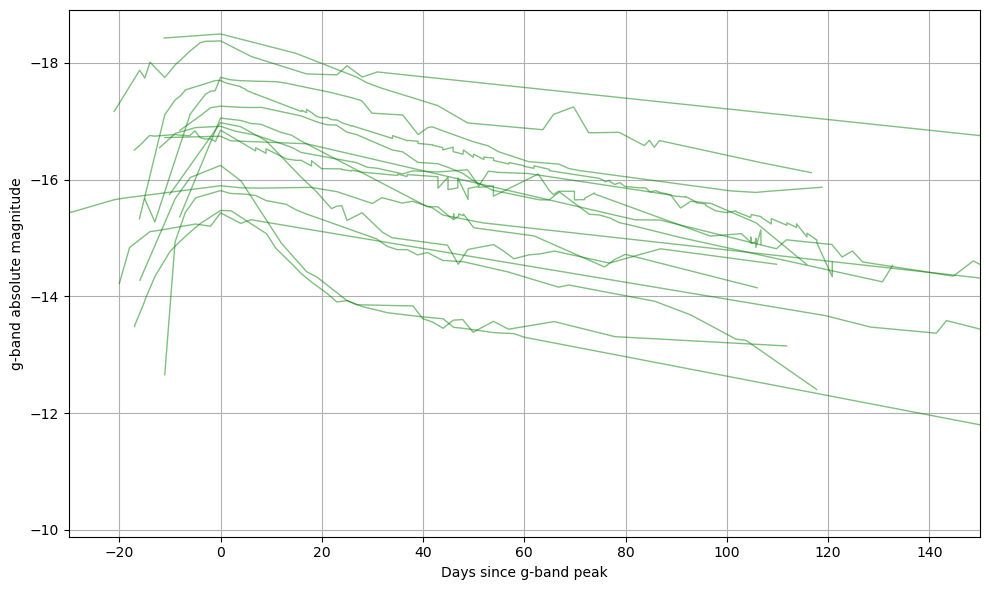

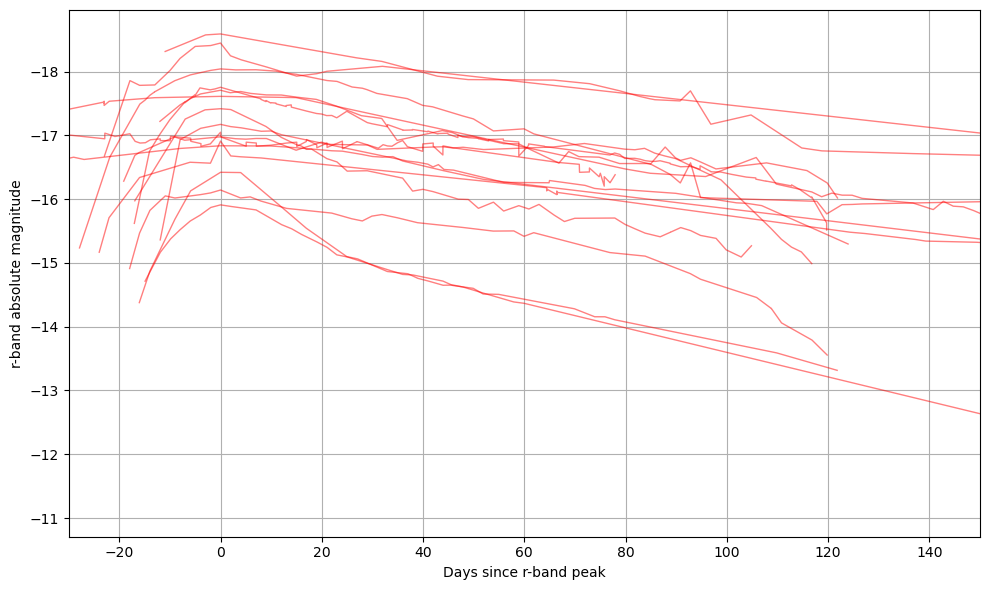

In [50]:
plot_lightcurves(ztf_selected_df, fid=1, absolute=True)
plot_lightcurves(ztf_selected_df, fid=2, absolute=True)

Try adjusting the selection criteria (e.g., minimum number of data points, required time span, or brightness variation), and observe how the number of selected light curves changes.

---

## Step 4: Reconstruct the Luminosity from the Observed Flux

In this step, we will try to reconstruct the luminosity of each supernova from its observed flux.  
To do this, we will combine several pieces of information:

- The observed apparent magnitude or flux in each band  
- The luminosity distance, estimated from redshift  
- Filter transmission curves (to relate observed flux to spectral energy)

But, all of the step has already experienced in Step 1.

---
---

## Assignment 2: Fit the SED and Visualize the Results

For well-observed samples, we can perform spectral energy distribution (SED) fitting by varying the blackbody temperature and radius of each supernova.

To evaluate the quality of the fit, it is helpful to plot the best-fit SED alongside the observed photometric data at each epoch.

In this assignment, you will randomly select one of the light curves and attempt to fit its SED using a blackbody model.

Tasks:
1. Select one light curve from the sample obtained in Step 3.
2. Convert the observed magnitudes into fluxes (with uncertainties).
3. Compute the blackbody SED for a given temperature and radius.
4. Fit the model SED to the observed fluxes at each epoch.
5. Repeat the fitting process for each time point in the light curve.
6. Plot the observed fluxes and the fitted SED curves for each epoch.
7. Finally, obtain the time evolution of the Luminosity, Temperature, and Radius.

In [51]:
## YOUR CODE HERE

---
---

`convert_mag_to_flux(magnitude, zero_point_flux)`

Converts an apparent magnitude to flux.

Arguments:
- `magnitude (float or np.ndarray)`: The apparent magnitude of the source.
- `zero_point_flux (Quantity)`: The zero-point flux in units of erg/s/cm^2/AA.

Returns:
- `flux (Quantity)`: The flux corresponding to the input magnitude in units of erg/s/cm^2/AA.

In [52]:
def convert_mag_to_flux(magnitude, zero_point_flux):
    return zero_point_flux * 10**(-magnitude / 2.5)

`fit_blackbody_sed(gr_pairs, distance_mpc, zp_g=..., zp_r=..., lambda_g=..., lambda_r=..., show_plot=False)`

Fit blackbody spectral energy distributions (SEDs) to a series of g- and r-band flux pairs, and optionally visualize the fits.

Arguments:
- `gr_pairs` (list of tuples): Each tuple contains (MJD, g_mag, g_mag_err, r_mag, r_mag_err).
- `distance_mpc` (float): Distance to the object in megaparsecs.
- `zp_g` (Quantity, optional): Zeropoint flux for the g-band. Default is `zp_ztf_g`.
- `zp_r` (Quantity, optional): Zeropoint flux for the r-band. Default is `zp_ztf_r`.
- `lambda_g` (Quantity): Central wavelength of the g-band (e.g. in Angstroms).
- `lambda_r` (Quantity): Central wavelength of the r-band.
- `show_plot` (bool, optional): If `True`, plot the observed fluxes and fitted blackbody SED for each epoch.

Returns:
- `result_list` (list of dicts): Each dictionary contains:
  - `'mjd'` (float): Observation time.
  - `'T'` (Quantity): Best-fit temperature in Kelvin.
  - `'R'` (Quantity): Best-fit photospheric radius in cm.
  - `'L_bol'` (Quantity): Bolometric luminosity in erg/s.


In [53]:
def fit_blackbody_sed(gr_pairs, distance_mpc,
                      zp_g=zp_ztf_g, zp_r=zp_ztf_r,
                      lambda_g=lambda_ztf_g, lambda_r=lambda_ztf_r,
                      show_plot=False):

    result_list = []
    d_cm = (distance_mpc * u.Mpc).to(u.cm)  # Convert distance to cm

    subplot_list = []  # For optional plotting

    # Initial guess: log(T), log(R)
    x0 = [np.log10(6000), np.log10(1e15)]

    for mjd, mag_g, sig_g, mag_r, sig_r in gr_pairs:
        # Convert magnitudes to fluxes
        flux_g = convert_mag_to_flux(mag_g, zp_g)
        flux_r = convert_mag_to_flux(mag_r, zp_r)

        # Estimate flux uncertainties via error propagation
        flux_sig_g = 0.4 * np.log(10) * flux_g * sig_g
        flux_sig_r = 0.4 * np.log(10) * flux_r * sig_r        

        # Define residuals between observed and model fluxes
        def residuals(params):
            logT, logR = params
            T = 10**logT * u.K
            R = 10**logR * u.cm

            B_g = compute_B_lambda(lambda_g, T)
            B_r = compute_B_lambda(lambda_r, T)
            f_g = compute_f_lambda(B_g, R, d_cm)
            f_r = compute_f_lambda(B_r, R, d_cm)

            res_g = ((f_g - flux_g) / flux_sig_g).value
            res_r = ((f_r - flux_r) / flux_sig_r).value

            return [res_g, res_r]

        # Bounds for [log(T), log(R)]
        bounds = [(np.log10(1e3), np.log10(5e4)), (np.log10(1e12), np.log10(1e17))]

        # Perform least-squares fitting
        res = least_squares(residuals, x0, bounds=bounds, x_scale='jac')

        if res.success:
            T_fit = 10**res.x[0] * u.K
            R_fit = 10**res.x[1] * u.cm
            L_bol = (4 * np.pi * R_fit**2 * sigma_sb * T_fit**4).to(u.erg / u.s)

            result_list.append({
                'mjd': mjd,
                'T': T_fit,
                'R': R_fit,
                'L_bol': L_bol
            })

            # Update initial guess for next iteration
            x0 = [np.log10(T_fit.value), np.log10(R_fit.value)]

            if show_plot:
                # Prepare wavelength grid for plotting the model SED
                wl_grid = np.linspace(3000, 9000, 500) * u.AA
                B_grid = compute_B_lambda(wl_grid, T_fit)
                f_grid = compute_f_lambda(B_grid, R_fit, d_cm)

                subplot_list.append({
                    'mjd': mjd,
                    'wl_grid': wl_grid,
                    'f_grid': f_grid,
                    'obs_lam': [lambda_g.value, lambda_r.value],
                    'obs_flux': [flux_g.value, flux_r.value],
                    'obs_flux_sig': [flux_sig_g.value, flux_sig_r.value]
                })

    # Optional plotting of SED fits
    if show_plot and subplot_list:
        n = len(subplot_list)
        ncols = 4
        nrows = int(np.ceil(n / ncols))

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows), sharex=False, sharey=False)
        axes = np.atleast_2d(axes).reshape(nrows, ncols)

        for ax, data in zip(axes.flat, subplot_list):
            ax.plot(data['wl_grid'].value, data['f_grid'].value, label='Model SED')
            ax.errorbar(data['obs_lam'], data['obs_flux'], yerr=data['obs_flux_sig'],
                        fmt='o', color='black', label='Observed flux', capsize=3)

            ax.set_title(f"MJD = {data['mjd']:.1f}")
            ax.set_yscale("log")
            ax.grid(True, which="both", ls="--")
            ax.legend(fontsize=8)

            # Dynamic y-limits
            all_fluxes = np.concatenate([data['f_grid'].value, data['obs_flux']])
            all_fluxes = all_fluxes[all_fluxes > 0]
            if len(all_fluxes) > 0:
                ax.set_ylim(all_fluxes.min() * 0.5, all_fluxes.max() * 2.0)

            # X label for bottom row only
            if ax in axes[-1]:
                ax.set_xlabel(r"Wavelength [$\mathrm{\AA}$]")

        # Y label for first column only
        for row in axes:
            row[0].set_ylabel(r"Flux [$\mathrm{erg/cm^{2}/s/\AA}$]")

        plt.tight_layout()
        plt.show()

    return result_list


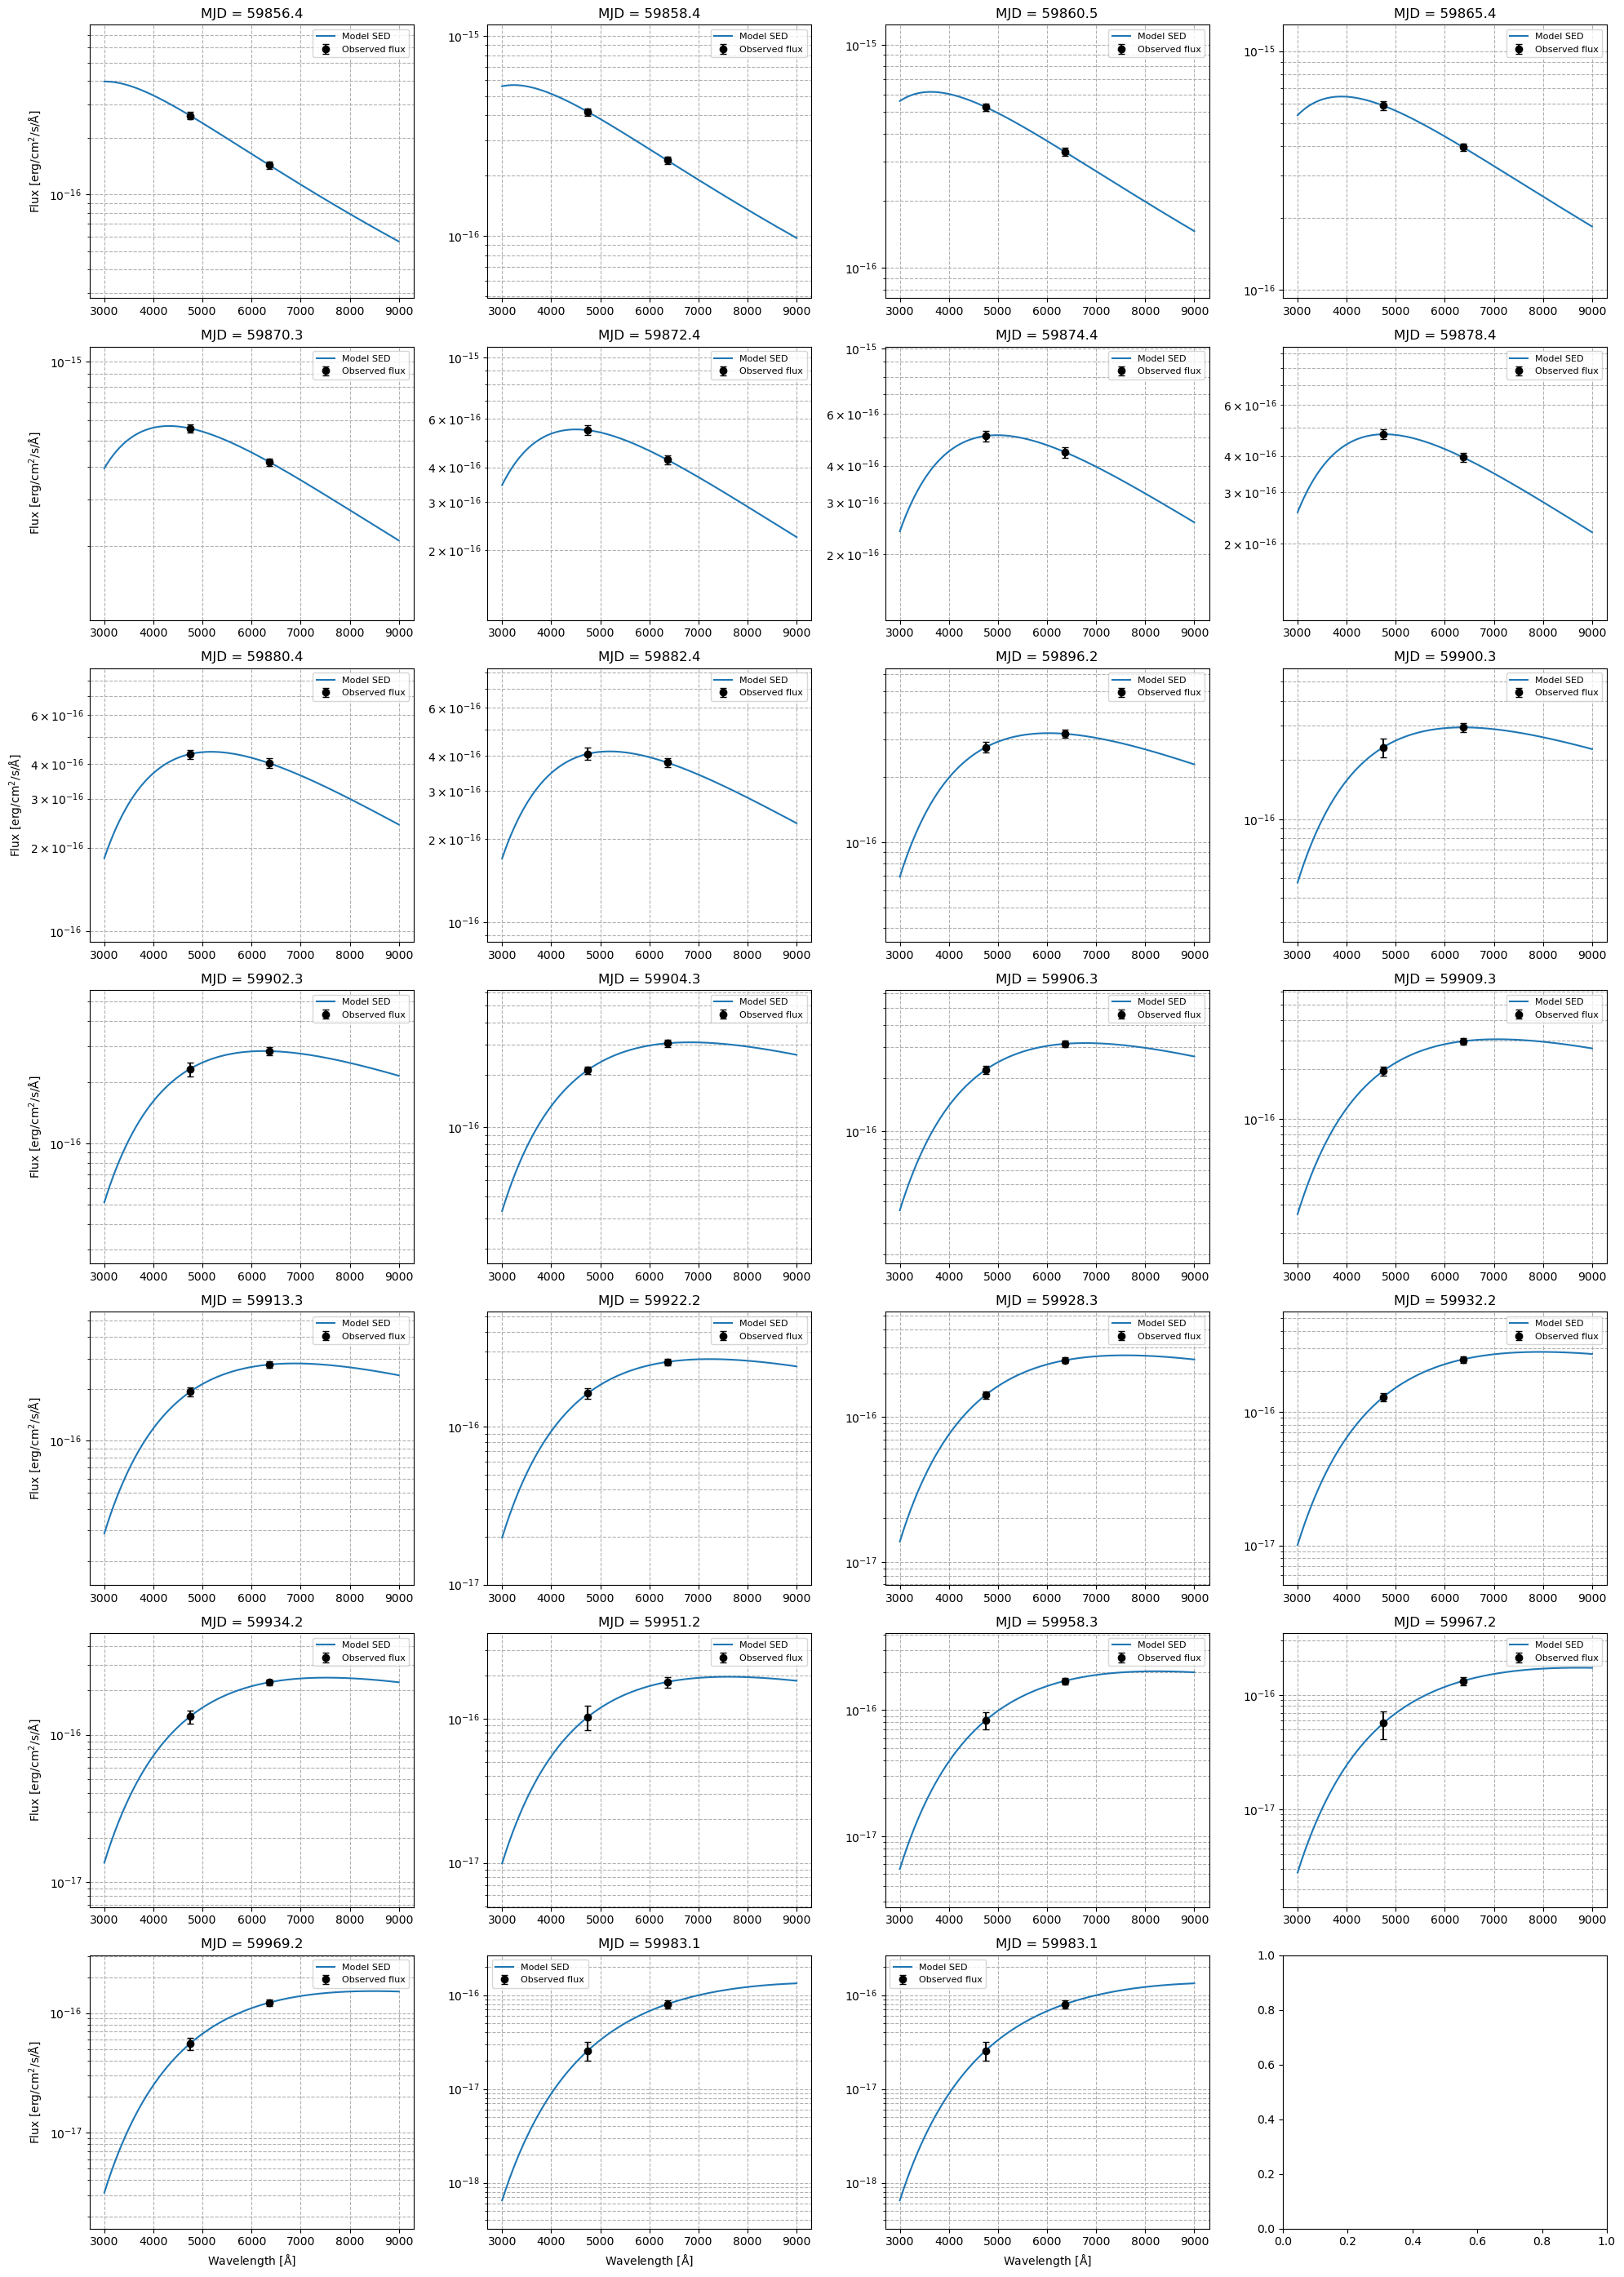

In [54]:
# Randomly sample one of the light curves and try performing SED fitting!
oid = ztf_selected_df["ztf_name"].sample(1).iloc[0]
df = ztf_selected_df[ztf_selected_df["ztf_name"] == oid]
distance = df['distance'].iloc[0]
disc = Time(df['discovery_date'].iloc[0]).mjd

file_path = os.path.join(lc_dir, f"{oid}.json")
with open(file_path, "r") as f:
    data = json.load(f)
    
detections = data.get("detections", [])
gr_pairs = get_gr_pairs(detections)
sed_fit = fit_blackbody_sed(gr_pairs, distance, show_plot=True)

---
---

### Supplementary Assignment: Plot the Bolometric Light Curve

In [55]:
## YOUR CODE HERE

---
---

Let's plot a 4-panel summary plot showing observed light curves and blackbody fit results.

`plot_sed_results_4panel(gr_pairs, sed_fit)`

Generate a 2×2 panel plot summarizing photometric data and SED fitting results for a transient or variable object.

Arguments:
- `gr_pairs` (list of tuples): Observational data, where each tuple contains:
  - `MJD`, `g_mag`, `g_mag_err`, `r_mag`, `r_mag_err`
- `sed_fit` (list of dicts): Output from `fit_blackbody_sed`, each dict containing:
  - `'mjd'`: Observation time
  - `'T'`: Best-fit temperature (Quantity)
  - `'R'`: Best-fit radius (Quantity)
  - `'L_bol'`: Bolometric luminosity (Quantity)

Returns:
- `None`: Displays a 4-panel plot with:
  1. g- and r-band light curves (top-left)
  2. Bolometric luminosity over time (top-right)
  3. Radius evolution (bottom-left)
  4. Temperature evolution (bottom-right)


In [56]:
def plot_sed_results_4panel(gr_pairs, sed_fit):

    # Extract SED fit results
    mjd_sed = [res['mjd'] for res in sed_fit]
    T_sed = [res['T'].value for res in sed_fit]
    R_sed = [res['R'].to(u.cm).value for res in sed_fit]
    L_sed = [res['L_bol'].to(u.erg / u.s).value for res in sed_fit]

    # Extract photometric data
    mjd_gr = [row[0] for row in gr_pairs]
    mag_g = [row[1] for row in gr_pairs]
    sig_g = [row[2] for row in gr_pairs]
    mag_r = [row[3] for row in gr_pairs]
    sig_r = [row[4] for row in gr_pairs]

    # Create a 2x2 panel figure
    fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

    # Top-left: g- and r-band light curves
    axs[0, 0].invert_yaxis()  # Brighter magnitudes are lower
    axs[0, 0].errorbar(mjd_gr, mag_g, yerr=sig_g, fmt='o', color='green',
                      label='g-band', markersize=5)
    axs[0, 0].errorbar(mjd_gr, mag_r, yerr=sig_r, fmt='o', color='red',
                      label='r-band', markersize=5)
    axs[0, 0].set_ylabel("Magnitude")
    axs[0, 0].set_title("Observed Light Curves")
    axs[0, 0].legend()
    axs[0, 0].grid(True, which="both", ls="--")

    # Top-right: bolometric luminosity
    axs[0, 1].scatter(mjd_sed, L_sed, color='tab:blue')
    axs[0, 1].set_ylabel("L_bol [erg/s]")
    axs[0, 1].set_yscale('log')
    axs[0, 1].set_title("Bolometric Light Curve")
    axs[0, 1].grid(True, which="both", ls="--")

    # Bottom-left: radius evolution
    axs[1, 0].scatter(mjd_sed, R_sed, color='tab:green')
    axs[1, 0].set_ylabel("Radius [cm]")
    axs[1, 0].set_xlabel("MJD")
    axs[1, 0].set_yscale('log')
    axs[1, 0].set_title("Radius Evolution")
    axs[1, 0].grid(True, which="both", ls="--")

    # Bottom-right: temperature evolution
    axs[1, 1].scatter(mjd_sed, T_sed, color='tab:red')
    axs[1, 1].set_ylabel("Temperature [K]")
    axs[1, 1].set_xlabel("MJD")
    axs[1, 1].set_title("Temperature Evolution")
    axs[1, 1].grid(True, which="both", ls="--")

    plt.tight_layout()
    plt.show()


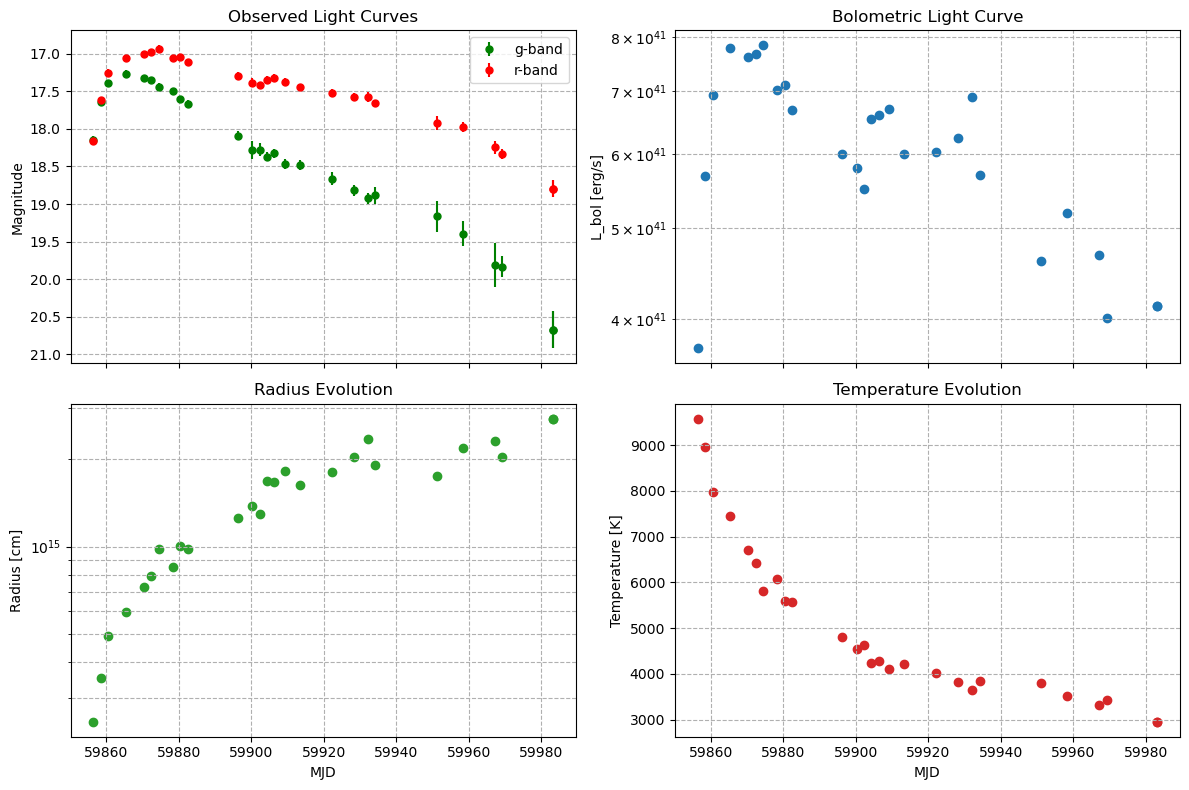

In [57]:
plot_sed_results_4panel(gr_pairs, sed_fit)

---

## Step 5: Fitting the Light Curve by a Simple Plateau Model

In this step, we fit the bolometric light curves of supernovae using a simple model. 

Type II supernovae, especially for Type IIP supernovae, have a characteristic phase keeping constant luminosity over several 10 days: Plateau phase.

We will model this phase as follows:

$$
L(t) =
\begin{cases}
L_{\mathrm{plateau}} & (t_0 < t < t_0 + t_{\mathrm{plateau}}) \\
L_{\mathrm{plateau}} \cdot e^{-(t - t_{\mathrm{end}})/\tau_{\mathrm{decay}}} & (t > t_{\mathrm{end}})
\end{cases}
$$

where:
- $L_{\mathrm{plateau}}$: Plateau luminosity  
- $t_0$: Explosion time (here $t_0=0$) 
- $t_{\mathrm{plateau}}$: Plateau duration  
- $t_{\mathrm{end}} = t_0 + t_{\mathrm{plateau}} = t_{\mathrm{plateau}}$
- $\tau_{\mathrm{decay}}$: Characteristic decay time in the tail phase (e.g., Radioactive decay)

---
---

## Assignment 3: Fit the Bolometric Light Curve Using a Simple Plateau Model

In Step 4, we constructed the bolometric light curve of a supernova.
In this assignment, your task is to fit the light curve using a simple plateau model commonly used to describe Type IIP supernovae.

If the fit appears successful, try applying the same model to all the selected samples from Step 3.

In [58]:
## YOUR CODE HERE

---
---

`compute_plateau_model(t, L_plateau, t_plateau, tau_decay)`

Compute the bolometric luminosity of a Type IIP supernova using a simplified plateau + exponential decay model.

Arguments:
- `t` (array-like): Time since explosion, in days.
- `L_plateau` (float): Plateau luminosity in erg/s.
- `t_plateau` (float): Plateau duration in days.
- `tau_decay` (float): Characteristic exponential decay timescale in days.

Returns:
- `L` (array): Bolometric luminosity at each time point, in erg/s.

`residuals_for_plateau_fit(params, t, L_obs)`

Compute residuals between observed and model-predicted luminosities in logarithmic space, for least-squares fitting.

Arguments:
- `params` (list or array): Model parameters `[L_plateau, t_plateau, tau_decay]`.
- `t` (array-like): Time array (days since explosion).
- `L_obs` (array-like): Observed bolometric luminosities in erg/s.

Returns:
- `residuals` (array): Difference between log(model) and log(observed) luminosities.


In [59]:
def compute_plateau_model(t, L_plateau, t_plateau, tau_decay):
    
    # Convert inputs to physical units
    t = t * u.day
    L_plateau = L_plateau * (u.erg/u.s)
    t_plateau = t_plateau * u.day
    tau_decay = tau_decay * u.day
    
    # Luminosity as a function of time
    L_decay = L_plateau * np.exp(-(t - t_plateau) / tau_decay)
    L = np.where(t < t_plateau, L_plateau, L_decay)
    
    return L.to(u.erg/u.s).value

def residuals_for_plateau_fit(params, t, L_obs):

    # Unpack parameters
    L_plateau, t_plateau, tau_decay = params

    # Compute model luminosity
    model_L = compute_plateau_model(t, L_plateau, t_plateau, tau_decay)

    # Avoid log(0) by applying a floor to model luminosity
    model_L = np.clip(model_L, 1e-20, np.inf)

    # Return residuals in log-luminosity space
    return np.log10(model_L) - np.log10(L_obs)

In [60]:
mjd_sed = np.array([res['mjd'] for res in sed_fit])
day_sed = mjd_sed - disc
day_fit = np.linspace(day_sed.min(), day_sed.max(), 300)

L_bol = np.array([res['L_bol'].value for res in sed_fit])

p0_plateau = [1e42, 50, 50] # L_plateau, t_plateau, tau_decay
bounds_plateau = ([1e39, 10, 1], [1e45, 200, 200])
res_plateau = least_squares(residuals_for_plateau_fit, p0_plateau, bounds=bounds_plateau, 
                           args=(day_sed, L_bol), x_scale='jac')
if res_plateau.success:
    L_fit = compute_plateau_model(day_fit, *res_plateau.x)
    L_plateau_fit, t_plateau_fit, tau_decay_fit = res_plateau.x
    print("Plateau Model Fit Results:")
    print(f"L_plateau = {L_plateau_fit:.2e} erg/s")
    print(f"t_plateau = {t_plateau_fit:.2e} day")
    print(f"tau_decay = {tau_decay_fit:.2f} day")

Plateau Model Fit Results:
L_plateau = 6.43e+41 erg/s
t_plateau = 7.14e+01 day
tau_decay = 119.89 day


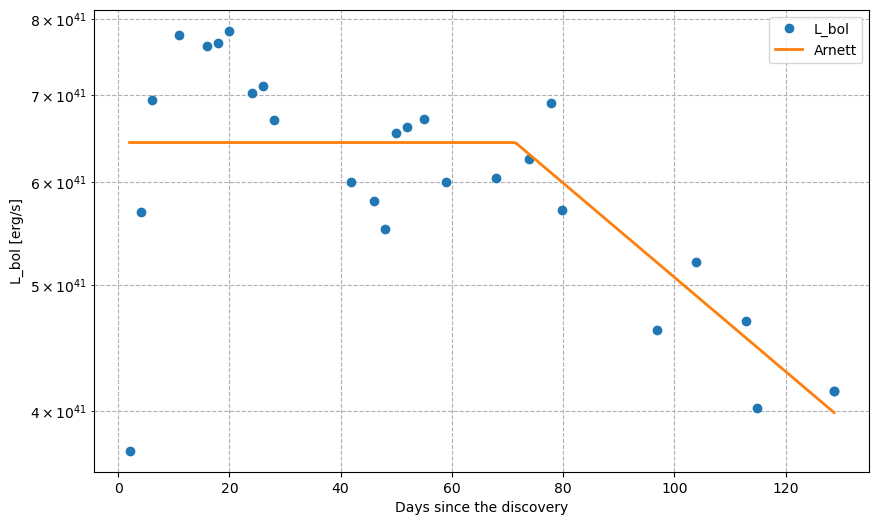

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(day_sed, L_bol, 'o', label='L_bol')
plt.plot(day_fit, L_fit, label='Arnett', lw=2)
plt.xlabel("Days since the discovery")
plt.ylabel("L_bol [erg/s]")
plt.yscale("log")
plt.legend()
plt.grid(True, which='both', ls='--')
plt.show()

Finally, we will fit the light curves for all selected supernovae using the plateau model.

In [62]:
# Initialize result lists
L_plateau_list = []
t_plateau_list = []
tau_decay_list = []


def append_nan():
    """Append NaN to all result lists"""
    L_plateau_list.append(np.nan)
    t_plateau_list.append(np.nan)
    tau_decay_list.append(np.nan)


# Loop through ZTF objects
for idx, row in ztf_selected_df.iterrows():
    try:
        oid       = row["ztf_name"]
        distance  = row["distance"]
        disc_mjd  = Time(row["discovery_date"]).mjd

        file_path = os.path.join(lc_dir, f"{oid}.json")
        if not os.path.exists(file_path):
            print(f'Error: no file exist: {oid}')
            append_nan()
            continue

        # Load JSON file
        with open(file_path, "r") as f:
            data = json.load(f)
        detections = data.get("detections", [])

        # Perform SED fitting
        gr_pairs = get_gr_pairs(detections)
        sed_fit = fit_blackbody_sed(gr_pairs, distance)
        if not sed_fit:
            print(f'Error: fail of SED fitting: {oid}')
            append_nan()
            continue

        # Prepare time and L_bol arrays
        mjd_sed = np.array([d["mjd"] for d in sed_fit])
        L_bol   = np.array([d["L_bol"].value for d in sed_fit])
        day_sed = mjd_sed - disc_mjd

        # Plateau model fit
        p0_plateau = [1e42, 50, 50] # L_plateau, t_plateau, tau_decay
        bounds_plateau = ([1e39, 10, 1], [1e45, 200, 200])
        res_plateau = least_squares(residuals_for_plateau_fit, p0_plateau, bounds=bounds_plateau, 
                                    args=(day_sed, L_bol), x_scale='jac')
        if not res_plateau.success:
            print(f'Error: fail of Arnett fitting: {oid}')
            append_nan()
            continue

        # Store fit results
        L_plateau_fit, t_plateau_fit, tau_decay_fit = res_plateau.x
        L_plateau_list.append(np.max(L_bol))
        t_plateau_list.append(t_plateau_fit)
        tau_decay_list.append(tau_decay_fit)

    except Exception:
        append_nan()
        continue

# Add results to the DataFrame
ztf_selected_df["L_plateau_peak"] = L_plateau_list
ztf_selected_df["t_plateau_fit"]  = t_plateau_list
ztf_selected_df["tau_decay_fit"]  = tau_decay_list

In [63]:
ztf_selected_df

,tns_name,internam_names,radeg,decdeg,redshift,discovery_date,discovery_mag,type,distance,mu,ztf_name,peak_abs_g_mag,peak_abs_r_mag,L_plateau_peak,t_plateau_fit,tau_decay_fit
5,SN2022aapf,"ZTF22abunrdy,ATLAS23aap,PS23azu",202.456518,-1.430790,0.021280,2022-11-17 13:07:24.997,17.4549,SN II,88.621746,34.737702,ZTF22abunrdy,-16.743813,-17.610582,3.508451e+42,35.959203,114.956152
18,SN2022acfz,"ATLAS22bngp,PS22mqy,ZTF22abybbud",114.396896,35.605512,0.013343,2022-11-30 11:24:44.064,18.0060,SN II,55.225606,33.710702,ZTF22abybbud,-15.895446,-16.836145,1.871658e+42,156.980498,116.793258
134,SN2022mxv,"ATLAS22qxp,ZTF22aaolwsd,,Gaia22dfc,PS22hho",357.771375,20.152481,0.014046,2022-06-18 13:05:36.384,18.2490,SN II,58.167235,33.823392,ZTF22aaolwsd,-17.698485,-17.753270,4.625550e+42,16.887767,100.121938
185,SN2022uop,"ZTF22abfzdkz,ATLAS22bfqg,PS22jrr",33.993255,1.592625,0.010000,2022-09-17 08:22:33.600,19.6000,SN II,41.280825,33.078742,ZTF22abfzdkz,-15.472322,-15.909612,6.353326e+41,36.889852,46.053229
201,SN2022wza,"ZTF22abkkhao,Gaia22eey,ATLAS22bhxa",48.154708,45.209681,0.010000,2022-10-02 09:25:55.200,20.4200,SN II,41.280825,33.078742,ZTF22abkkhao,-15.813266,-16.142514,7.836796e+41,71.412186,119.888908
212,SN2022yyz,"ZTF22abrexqa,PSP22ag,ATLAS22bkpq",286.756471,28.997246,0.012200,2022-10-29 03:00:29.998,19.2934,SN II,50.449648,33.514291,ZTF22abrexqa,-15.431003,-16.909781,3.549073e+42,194.635536,86.164794
369,SN2023plh,"ZTF23aaxtmrr,ATLAS23rkk,PS23itf",51.015345,34.602836,0.035000,2023-08-14 10:07:47.004,19.4289,SN II,147.299577,35.841008,ZTF23aaxtmrr,-16.847661,-17.047927,2.274476e+42,121.662484,7.024457
424,SN2023vog,"ZTF23abmoxlu,ATLAS23uod,MASTER OT J094509.62+6...",146.290125,68.586589,0.014817,2023-10-21 10:15:06.002,18.5768,SN II,61.397064,33.940738,ZTF23abmoxlu,-17.054994,-17.171418,2.498727e+42,28.890499,200.000000
466,SN2024aasm,"ZTF24abrfiya,ATLAS24qfe,GOTO24iki",346.999416,-8.743635,0.043000,2024-11-08 02:56:53.998,19.1321,SN II,182.063527,36.301115,ZTF24abrfiya,-18.377015,-18.446315,2.792936e+43,10.000000,117.988995
470,SN2024aawr,"ZTF24absbhfe,ATLAS24qjb,GOTO24irq",144.427490,66.296708,0.023000,2024-11-11 08:37:47.003,18.6282,SN II,95.912158,34.909368,ZTF24absbhfe,-16.913263,-16.976668,2.710615e+42,106.542063,19.372309


In [64]:
print(f"mean plateau luminosity of Type II SNe is {ztf_selected_df['L_plateau_peak'].mean():.2e} erg/s")

mean plateau luminosity of Type II SNe is 4.88e+42 erg/s


---

# Discussions and Further Steps:

Today, we reviewed photometric systems and explored light curve modeling using observed data.

If you have extra time, consider exploring the following topics:

- Try changing the filters to those used by other telescopes (e.g., VLT, near-infrared telescopes), and estimate the expected magnitudes.
- Try querying transients directly via the TNS API (you’ll need to create an account). Retrieve other populations (e.g., SN Ia, TDEs, CVs...) and compare their light curve shapes.
- Simulate LSST observations using the temperature and radius you estimated earlier (see below).
- Try fitting the supernova light curves using more physical models (see below) and analyze the derived parameters. If the results seem unrealistic, consider possible reasons (some assumptions might not be appropriate).

---

Hereafter, please refer to `day2_sscne_ku_solution.ipynb` (the functions used in the following cell is defined in `day2_ccsne_ku_solution.ipynb`)

## Further Step 1: Simulate LSST Observation

We have obtained the time evolution of the blackbody temperature and radius for a supernova.
By interpolating these quantities over time, we can simulate how the supernova would appear in LSST's photometric bands (from g to y).

Note:
The data structure and utility functions depend on the definitions in your code.
Please refer to `day2_ccsne_ku_solution.ipynb` for implementation details.

In [65]:
def mock_observation_by_lsst(sed_fit, distance_mpc, filters=filters):
    
    distance = distance_mpc * u.Mpc
    
    # Interpolation setup
    mjd_sed = [res['mjd'] for res in sed_fit]
    T_sed = [res['T'].to(u.K).value for res in sed_fit]
    R_sed = [res['R'].to(u.cm).value for res in sed_fit]
    L_sed = [res['L_bol'].to(u.erg/u.s).value for res in sed_fit]
    
    T_interp = interp1d(mjd_sed, T_sed, kind='linear', fill_value="extrapolate")
    R_interp = interp1d(mjd_sed, R_sed, kind='linear', fill_value="extrapolate")

    # Define time grid (5 day interval)
    mjd_grid = np.arange(min(mjd_sed), max(mjd_sed), 5)
    
    filter_list = ['lsst_u', 'lsst_g', 'lsst_r', 'lsst_i', 'lsst_z', 'lsst_y']
    limiting_mag = {'lsst_u': 23.70, 'lsst_g': 24.97, 'lsst_r':24.52, 'lsst_i': 24.13, 'lsst_z': 23.56, 'lsst_y':22.55}
    mock_mags = {band: [] for band in filter_list}
    for mjd in mjd_grid:
        T = T_interp(mjd) * u.K
        R = R_interp(mjd) * u.cm
        for band in filter_list:
            
            zp, lambda_eff, filt = get_filter_table(filters, band)
            wl = np.linspace(1000, 12000, 2000) * u.AA
            B_lambda = compute_B_lambda(wl, T)
            f_lambda = compute_f_lambda(B_lambda, R, distance)
            f_fil = compute_filter_flux(f_lambda, wl, filt)
            mag = convert_flux_to_mag(f_fil, zp)
            mock_mags[band].append((mjd, mag))
    
    mock_mags_lsst = {}
    for band in filter_list:
        mag_data = mock_mags[band]  # List of tuples: (mjd, mag)
        mag_limit = limiting_mag[band]

        # detectable
        filtered = [(mjd, mag) for mjd, mag in mag_data if mag < mag_limit]
        mock_mags_lsst[band] = filtered
    
    return mock_mags_lsst

In [66]:
mock_mags_lsst = mock_observation_by_lsst(sed_fit, distance)

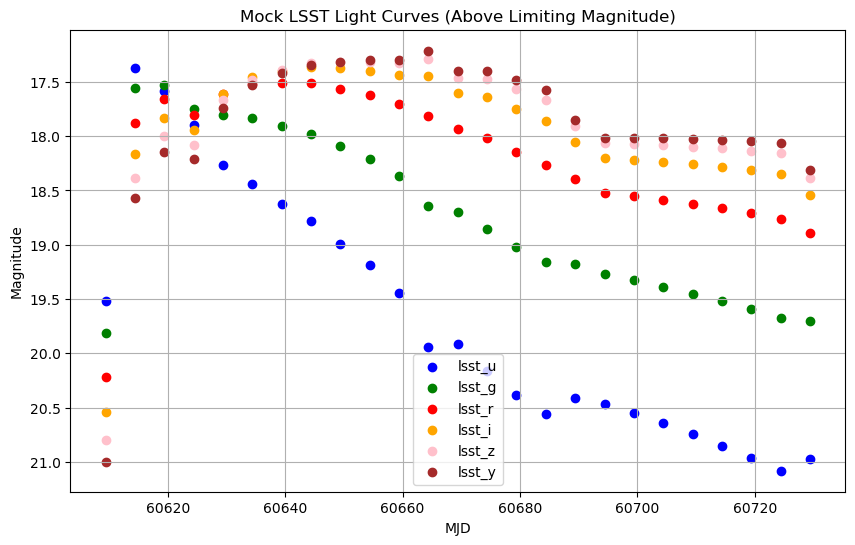

In [67]:
plt.figure(figsize=(10, 6))

filter_list = ['lsst_u', 'lsst_g', 'lsst_r', 'lsst_i', 'lsst_z', 'lsst_y']
band_color = {'lsst_u': 'blue', 'lsst_g': 'green', 'lsst_r': 'red', 'lsst_i': 'orange', 'lsst_z': 'pink', 'lsst_y': 'brown'}
for band in filter_list:
    
    mjd_vals, mag_vals = zip(*mock_mags_lsst[band])
    plt.scatter(mjd_vals, mag_vals, label=band, c = band_color[band])

plt.gca().invert_yaxis()
plt.xlabel("MJD")
plt.ylabel("Magnitude")
plt.title("Mock LSST Light Curves (Above Limiting Magnitude)")
plt.legend()
plt.grid(True)
plt.show()

---

## Further Step2: Fit by Physical Model

If we neglect the heating source (e.g., radioactive decay), we can analytically solve the following thermodynamics equation:

$$
\frac{dE_{\rm int}(t)}{dt} = -P\frac{dV}{dt} + L_{\rm heat} - L_{\rm cool} = -\frac{E_{\mathrm{int}}(t)}{R}\frac{dR}{dt} - L(t)
$$

where:
- $E_{\rm int}$: internal energy of the supernova ($\sim 10^{51}$ erg)
- $P$: pressure
- $V$: volume
- $R$: radius
- $L_{\rm heat}$: heating luminosity (here $L_{\rm heat}= 0$)
- $L_{\rm cool}$: cooling luminosity

Also, the luminosity detemined by photn diffusion is expressed as follows:
$$
L(t) = 4\pi r^2 \frac{c}{3\kappa\rho} \frac{\partial}{\partial r} (aT^4) \sim \frac{E_{\mathrm{int}(t)}}{t_{\mathrm{diff}}}
$$

where:
- $\kappa$: opacity
- $\rho$: density
- $a$: radiation constant
- $t_{\mathrm{diff}}$: diffusion timescale ($= \tau \frac{R_{\mathrm{ej}}}{c}$)
- $R_{\mathrm{ej}}$: ejecta radius ($R_{\mathrm{ej}} = R_{0} + v_{\mathrm{ej}}t$; where $R_{0}$ is the initial radius)
- $v_{\mathrm{ej}}$: ejecta velocity

Assuming one-zone model, we can introduce a characteristic timescale ($t_{\rm ch}$), which is a typical timescale that a supernova reaches its peak:
$$
t_{\mathrm{ch}} \approx \sqrt{t_{\mathrm{dyn}} t_{\mathrm{diff}}} = \left(\frac{3\kappa M_{\mathrm{ej}}}{4\pi c v_{\mathrm{ej}}}\right)^{1/2}
$$

where:
- $t_{\mathrm{dyn}}$: dynamical timescale ($= R_{\mathrm{ej}}/v_{\mathrm{ej}}$)
- $\kappa$: opacity
- $M_{\mathrm{ej}}$: ejecta mass
- $\tau$: optical depth

Furthermore, [Arnett (1982)](https://ui.adsabs.harvard.edu/abs/1982ApJ...253..785A/abstract) suggest that the characteristic timescale is expressed as

$$
t_{\mathrm{ch}} \approx \left(\frac{2\kappa M_{\mathrm{ej}}}{\beta \pi c v_{\mathrm{ej}}}\right)^{1/2}
$$
where:
- $\beta$: structure parameter ($\sim 13.8$)

Using the charcteristic timescale, the luminosity is expressed as follows:
$$
L(t) \sim \frac{E_{\mathrm{int}(t)}}{t_{\mathrm{ch}}} \frac{t+t_{0}}{t_{\mathrm{ch}}}
$$

where:
- $t_{0} = R_{0}/ v_{\mathrm{ej}}$

Thus, the thermodynamics equation is modified as follows:

$$
\frac{dE_{\rm int}(t)}{dt} = = -\frac{E_{\mathrm{int}}(t)}{t+t_{0}} - \frac{E_{\mathrm{int}(t)}}{t_{\mathrm{ch}}} \frac{t+t_{0}}{t_{\mathrm{ch}}}
$$

This equation can be analytically solved, and we obtain

$$
L(t) = \frac{E_{0}t_{0}}{t_{\mathrm{ch}}^2} \exp\left( -\frac{t^2 + 2t_{0}t}{2t_{\mathrm{ch}}^2} \right)
$$

where:
- $E_{0} = E_{\mathrm{int}}(0)$


This model might explain early phase of the light curve, let's try to fit this model, and derive physical properties like $M_{\mathrm{ej}}$

`compute_arnett_model(t, E_0, R_0, M_ej, v_ej, kappa)`

Compute the luminosity of an explosion using a simplified Arnett model.

Arguments:
- `t` (array-like): Time since explosion in days.
- `E_0` (float): Initial thermal energy in erg.
- `R_0` (float): Initial radius of the progenitor in cm.
- `M_ej` (float): Ejecta mass in solar masses.
- `v_ej` (float): Ejecta velocity in cm/s.
- `kappa` (float): Optical opacity in cm²/g.

Returns:
- `L` (array): Luminosity at each time in erg/s.


`residuals_for_arnett_fit(params, t, L_obs)`

Compute residuals between observed and model luminosities in log space, for use in fitting procedures.

Arguments:
- `params` (list or array): Model parameters `[E_0, R_0, M_ej, v_ej, kappa]`.
- `t` (array-like): Time array in days.
- `L_obs` (array-like): Observed bolometric luminosity in erg/s.

Returns:
- `residuals` (array): Logarithmic residuals between model and observed luminosity.


In [68]:
def compute_arnett_model(t, E_0, R_0, M_ej, v_ej, kappa):

    # Convert inputs to physical units
    t = t * u.day
    E_0 = E_0 * u.erg
    R_0 = R_0 * u.cm
    M_ej = M_ej * M_sun
    v_ej = v_ej * (u.cm/u.s)
    kappa = kappa * (u.cm**2 / u.g)

    # Model constants
    beta = 13.8  # geometric factor
    t_ch = ((2 * kappa * M_ej / (beta * c * v_ej))**0.5)  # characteristic timescale
    t_0 = R_0 / v_ej  # expansion timescale

    # Luminosity as a function of time
    L = (E_0 * t_0 / t_ch**2 * np.exp(-(t**2 + 2 * t_0 * t) / (2 * t_ch**2)))

    return L.to(u.erg/u.s).value


def residuals_for_arnett_fit(params, t, L_obs):

    # Unpack parameters
    E_0, R_0, M_ej, v_ej, kappa = params

    # Compute model luminosity
    model_L = compute_arnett_model(t, E_0, R_0, M_ej, v_ej, kappa)

    # Avoid log(0) by applying a floor to model luminosity
    model_L = np.clip(model_L, 1e-20, np.inf)

    # Return residuals in log-luminosity space
    return np.log10(model_L) - np.log10(L_obs)


In [69]:
mjd_sed = np.array([res['mjd'] for res in sed_fit])
day_sed = mjd_sed - disc
day_fit = np.linspace(day_sed.min(), day_sed.max(), 300)

L_bol = np.array([res['L_bol'].value for res in sed_fit])

p0_arnett = [1e51, 1e13, 10, 5e8, 0.1] # E_0, R_0, M_ej, v_ej, kappa
bounds_arnett = ([1e49, 1e11, 5, 1e8, 0.01], [1e53, 1e15, 50, 3e9, 1])
res_arnett = least_squares(residuals_for_arnett_fit, p0_arnett, bounds=bounds_arnett, 
                           args=(day_sed, L_bol), x_scale='jac')
if res_arnett.success:
    L_arnett_fit = compute_arnett_model(day_fit, *res_arnett.x)
    E_0_fit, R_0_fit, M_ej_fit, v_ej_fit, kappa_fit = res_arnett.x
    print("Arnett Physical Model Fit Results:")
    print(f"  E_0   = {E_0_fit:.2e} erg")
    print(f"  R_0   = {R_0_fit:.2e} cm")
    print(f"  M_ej  = {M_ej_fit:.2f} Msun")
    print(f"  v_ej  = {v_ej_fit:.2e} cm/s")
    print(f"  kappa = {kappa_fit:.2e} cm2/s")

Arnett Physical Model Fit Results:
  E_0   = 1.00e+53 erg
  R_0   = 3.20e+14 cm
  M_ej  = 32.72 Msun
  v_ej  = 3.00e+08 cm/s
  kappa = 6.10e-01 cm2/s


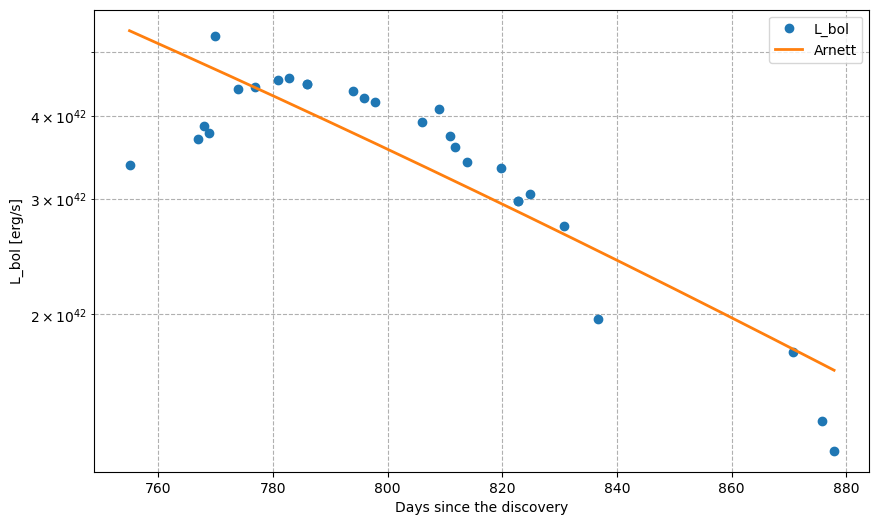

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(day_sed, L_bol, 'o', label='L_bol')
plt.plot(day_fit, L_arnett_fit, label='Arnett', lw=2)
plt.xlabel("Days since the discovery")
plt.ylabel("L_bol [erg/s]")
plt.yscale("log")
plt.legend()
plt.grid(True, which='both', ls='--')
plt.show()